## 1. EDA

In [2]:
# Imports

import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import seaborn as sns
from sklearn import metrics
from sklearn import feature_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline
sns.set

import gc

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Import dataset
df_o = pd.read_csv("wine.csv")
print(df_o.shape)
df_o.head()

(4898, 13)


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,taste
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,normal
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,normal
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,normal
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,normal
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,normal


Dataset has almost 5000 records and 13 variables

In [4]:
# Changing dots into underscores
for t in df_o.columns:
    df_o.rename(columns=lambda t: t.replace('.','_'), inplace=True)

In [5]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         4898 non-null   float64
 1   volatile_acidity      4898 non-null   float64
 2   citric_acid           4898 non-null   float64
 3   residual_sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free_sulfur_dioxide   4898 non-null   float64
 6   total_sulfur_dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
 12  taste                 4898 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 497.6+ KB


From this 13 variables, one is string variable and 12  are numeric ones

In [6]:
# No NA data
df_o.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
taste                   0
dtype: int64

In [7]:
# No null data
df_o.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
taste                   0
dtype: int64

Zero nulls or NAs in the dataset

As I want to study this data as a classification problem, I will do as follows:

For purpose of this study I will divide data into to categories:
1 - for observations where quality >=6 - meaning it is good quality wine
0 - for observations where quality <6 - meaning it is bad quality wine

In [8]:
df_o["rate"]=1
for index in df_o.index:
    if df_o.loc[index,"quality"]<6:
        df_o.loc[index, "rate"]=0

In [9]:
df_o.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,taste,rate
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,normal,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,normal,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,normal,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,normal,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,normal,1


In [10]:
# Dateset is more or less balanced
df_o.rate.value_counts()

1    3258
0    1640
Name: rate, dtype: int64

Dataset is more or less balanced

In [11]:
df_o.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'taste', 'rate'],
      dtype='object')

In [12]:
# Assinging columns to variables
df = df_o.copy()

target = "rate"

features = df.columns.tolist()
features.remove(target)
features.remove('quality')
features.remove('taste')
print(features)

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [13]:
# Now check out summary statistcs using .describe() method
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,rate
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909,0.665169
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639,0.471979
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000,1.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000,1.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000,1.000000


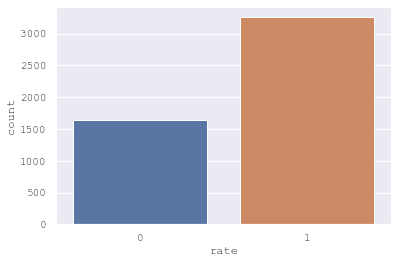

In [14]:
# Plot of target variable
sns.set(font='Courier New')
sns.countplot(df[target])

As it was said before target variable look more or less balanced

In [15]:
# Skewness
df.skew()

fixed_acidity           0.647751
volatile_acidity        1.576980
citric_acid             1.281920
residual_sugar          1.077094
chlorides               5.023331
free_sulfur_dioxide     1.406745
total_sulfur_dioxide    0.390710
density                 0.977773
pH                      0.457783
sulphates               0.977194
alcohol                 0.487342
quality                 0.155796
rate                   -0.700187
dtype: float64

Variables such as:\
<i> volatile_acidity, citric_acid, residual_sugar ,chlorides ,density ,sulphates ,free_sulfur_dioxide </i>\
seems to be right skewed.\
And <i> total_sulfur_dioxide, pH, alcohol </i> appears to be rather normally distributed.\
<i>quality</i> which is a base for my target variable also seems to has normal distribution.



In [16]:
# Creating function to plot histograms
# Function will make 3 plots for each variable (for all observation and separately for good and bad wines)
def histograms(x, color=None, kde=True):
    f, axes = plt.subplots(ncols=3, figsize=(15,10), sharex=False)
    ax1=sns.distplot(df[x], color=color, ax=axes[0])
    ax2=sns.distplot(df[x][df[target]==1], color=color, ax=axes[1])
    ax3=sns.distplot(df[x][df[target]==0], color=color, ax=axes[2])
    ax1.set_title(f"{x}'s histogram \n for " + r"$\bf{all}$" + " wines", fontsize=14)
    ax2.set_title(f"{x}'s histogram \n for " + r"$\bf{" + 'good' + "}$" + " wines", fontsize=14)
    ax3.set_title(f"{x}'s histogram \n for " + r"$\bf{" + 'bad' + "}$" + " wines", fontsize=14)
    plt.show()

In [17]:
# Colour map for plots
cmaps= ['darkred', 'chocolate', 'gold', 'darkolivegreen', 'lawngreen', 'lightseagreen', 'deepskyblue', 'royalblue', 'rebeccapurple', 'deeppink', 'slategray']

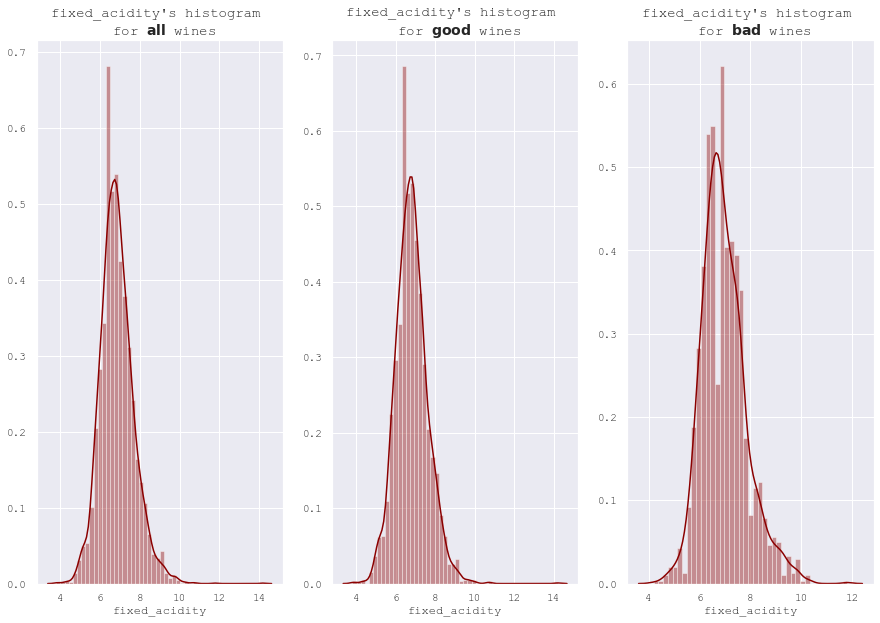

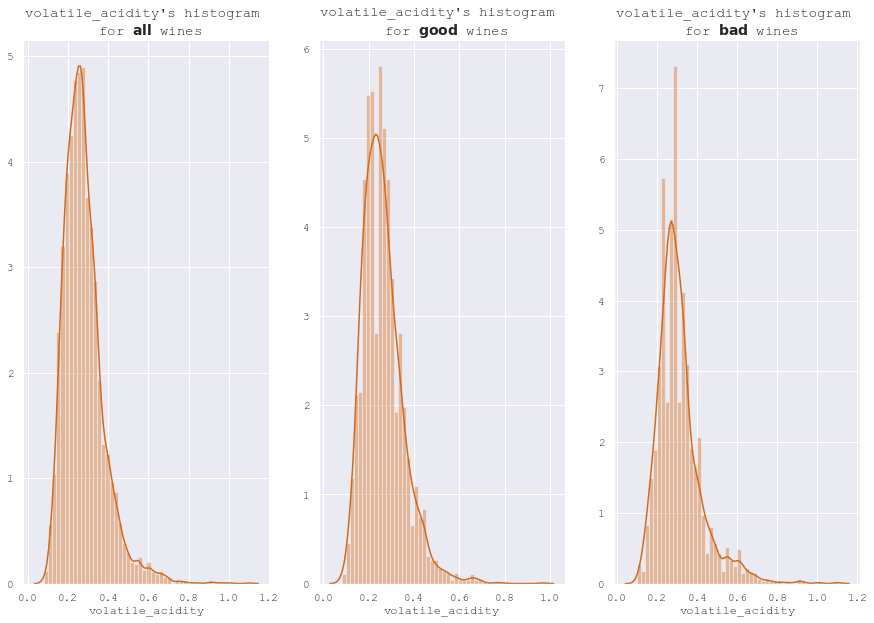

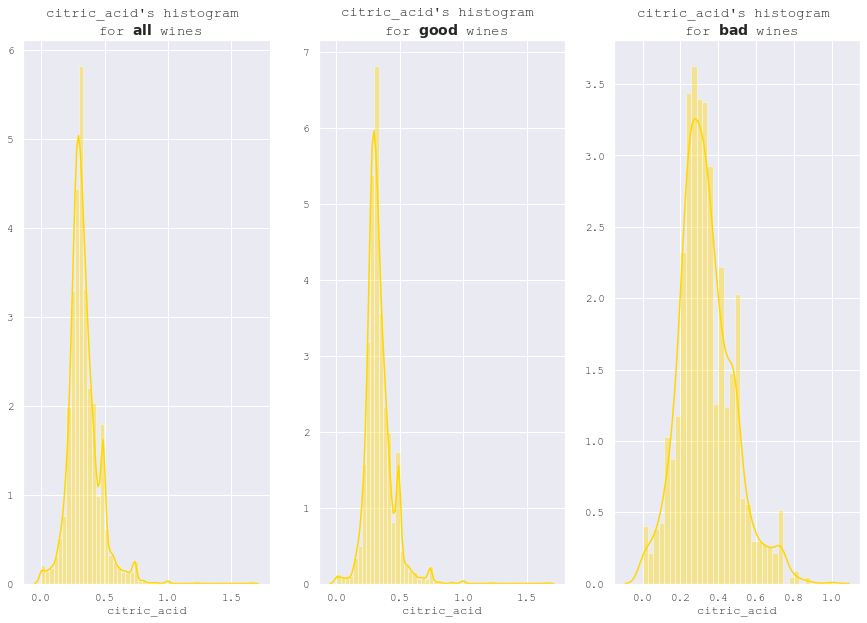

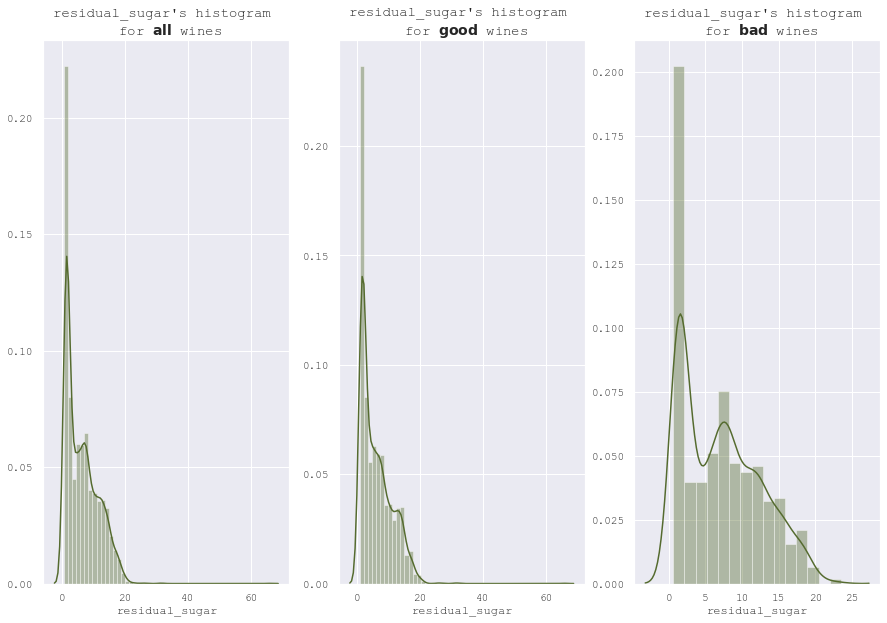

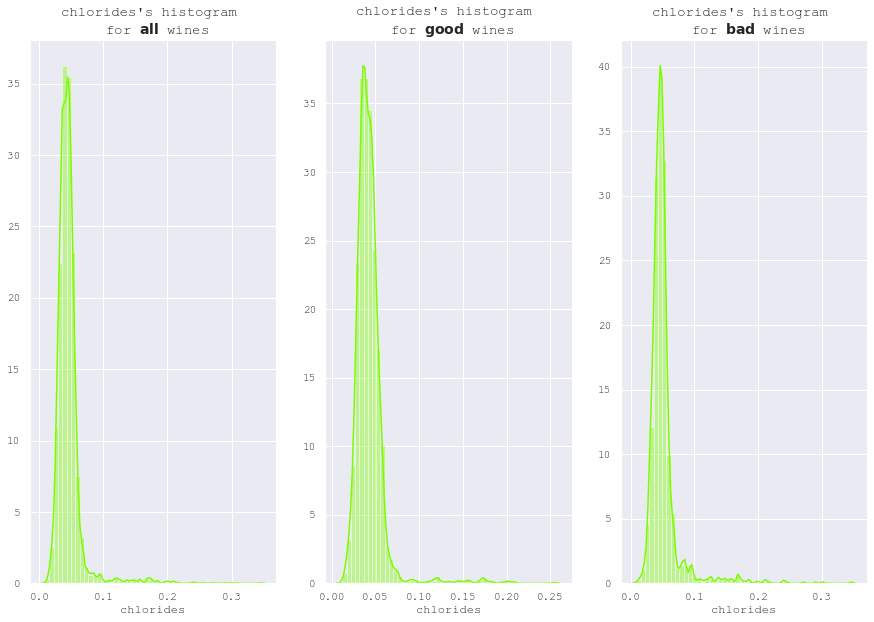

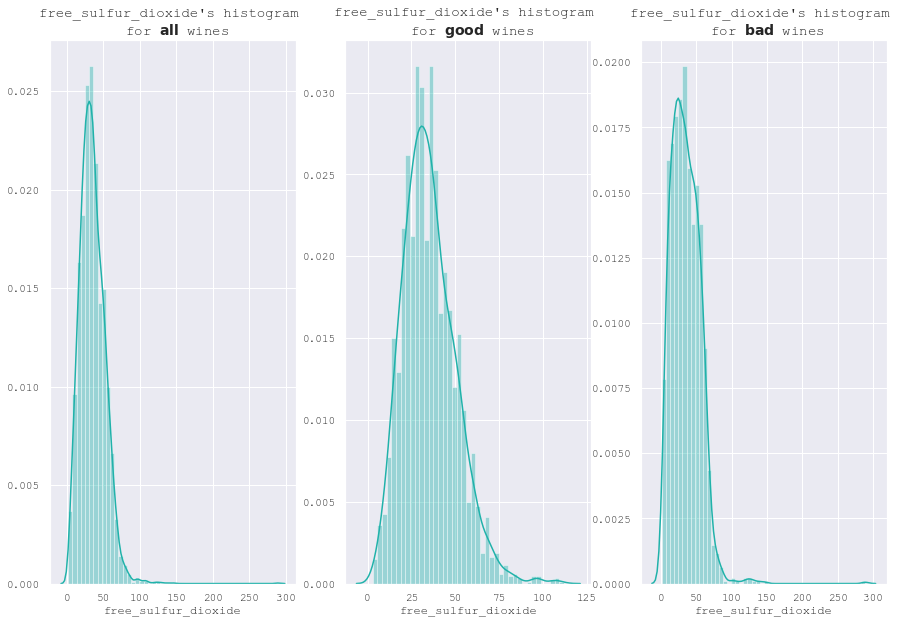

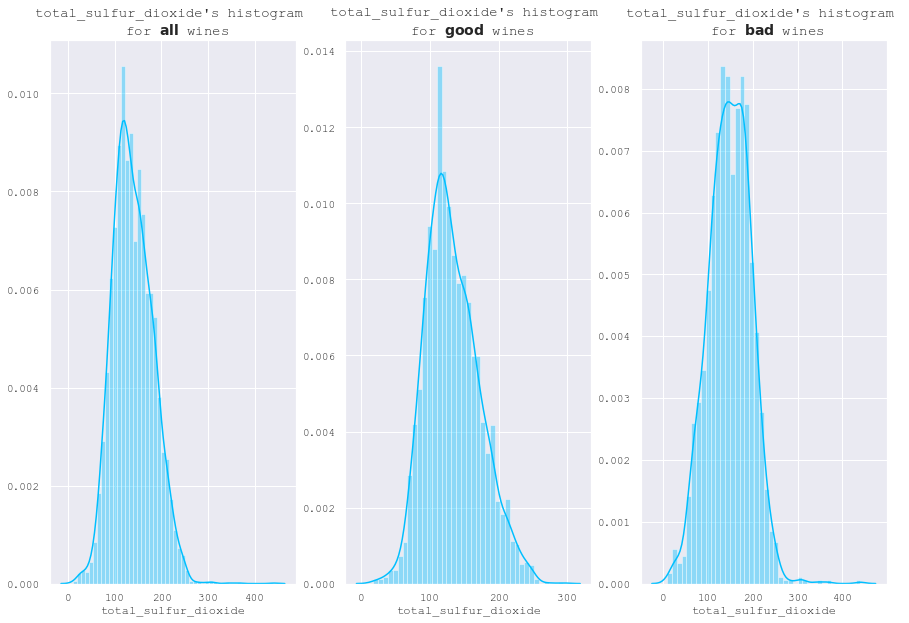

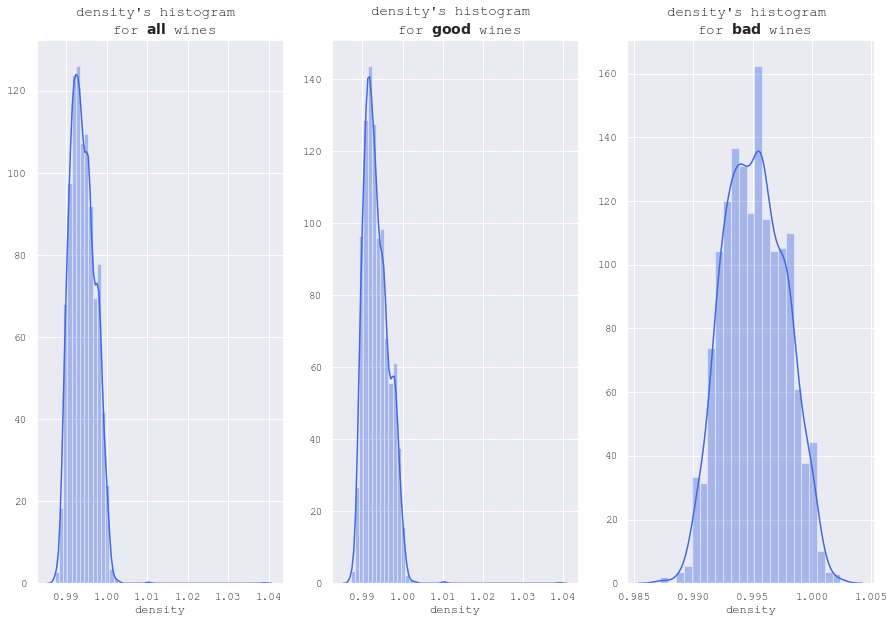

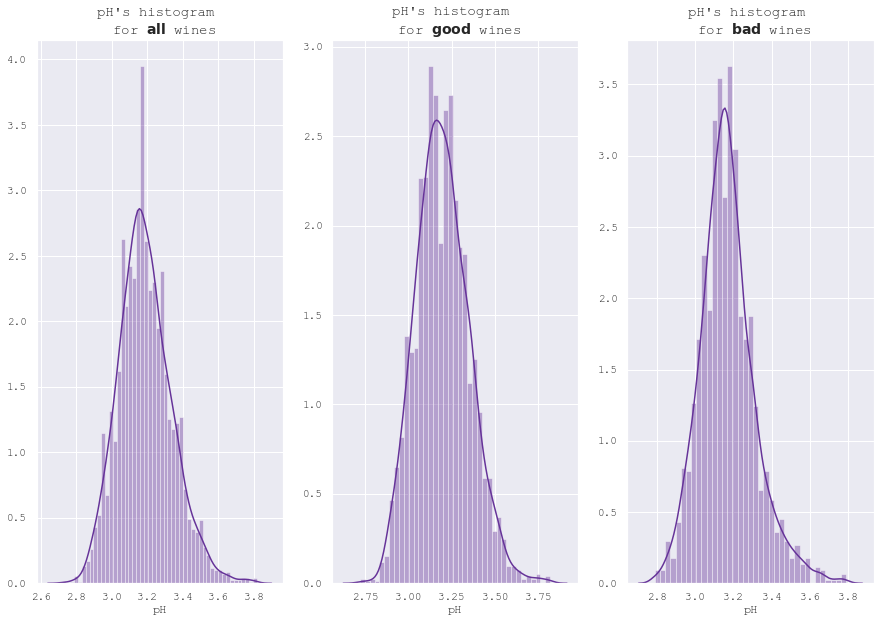

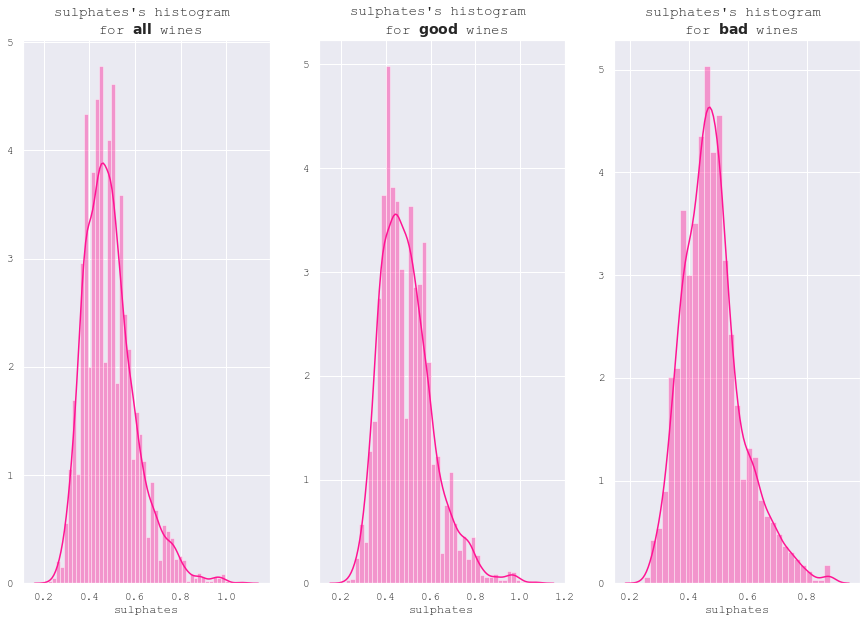

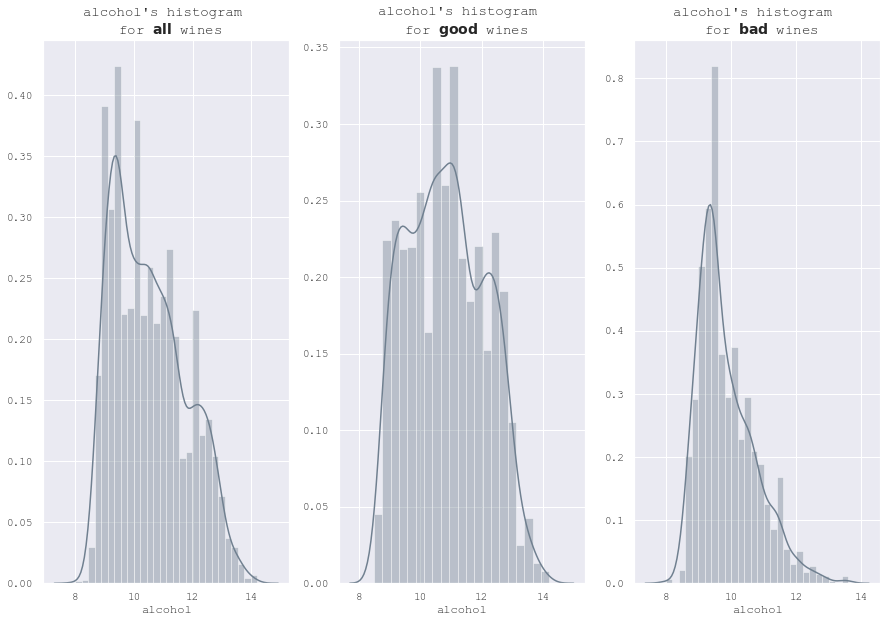

In [18]:
# Now I want to make plots for all my feature variables
for var, col in zip(features,cmaps) :
    histograms(x=var, color=col)

After looking at histograms of each variable, assumptions made on skweness can be hold. Almost all of variables are positively skewed

In [19]:
def boxplots(x, color=None):
    f, axes = plt.subplots(ncols=3, figsize=(15,10), sharex=False)
    ax1=sns.boxplot(df[x], color=color, ax=axes[0], orient='v')
    ax2=sns.boxplot(df[x][df[target]==1], color=color, ax=axes[1], orient='v')
    ax3=sns.boxplot(df[x][df[target]==0], color=color, ax=axes[2], orient='v')
    sns.set(font='Courier New')
    ax1.set_title(f"{x}'s boxplot \n for " + r"$\bf{all}$" + " wines", fontsize=14)
    ax2.set_title(f"{x}'s boxplot \n for " + r"$\bf{" + 'good' + "}$" + " wines", fontsize=14)
    ax3.set_title(f"{x}'s boxplot \n for " + r"$\bf{" + 'bad' + "}$" + " wines", fontsize=14)
    plt.show()

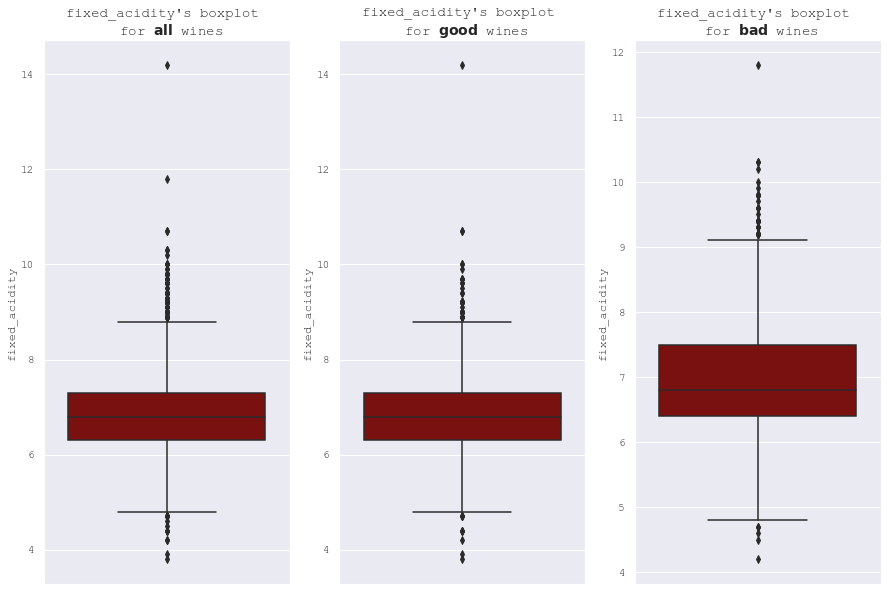

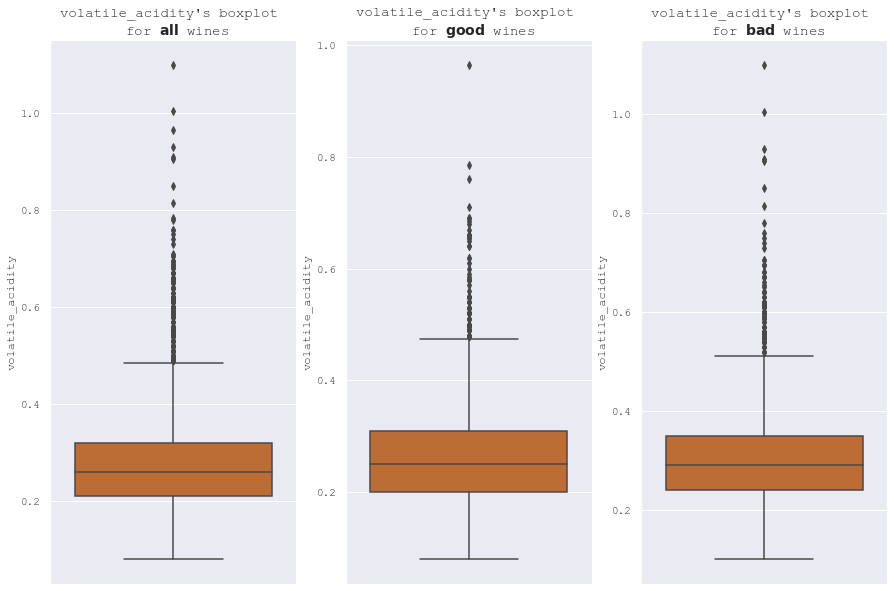

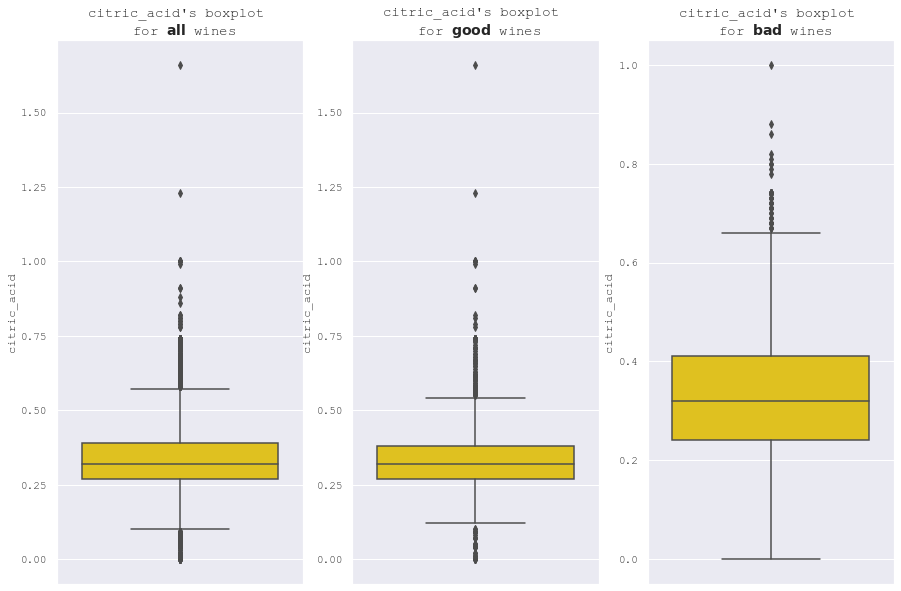

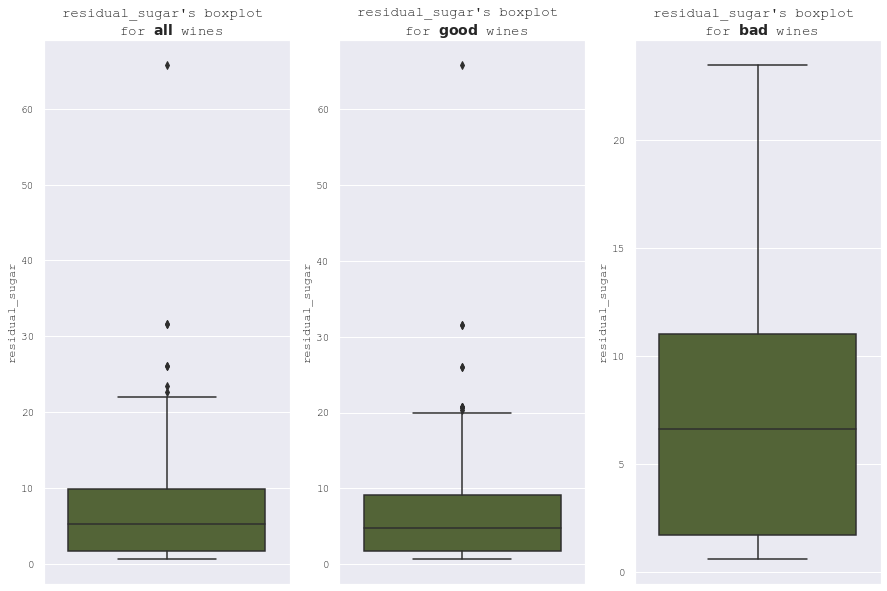

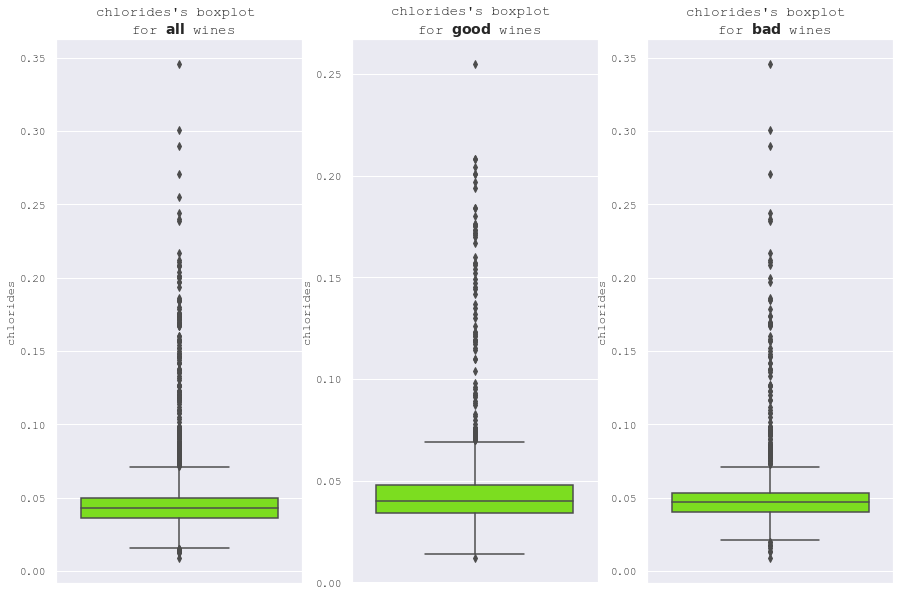

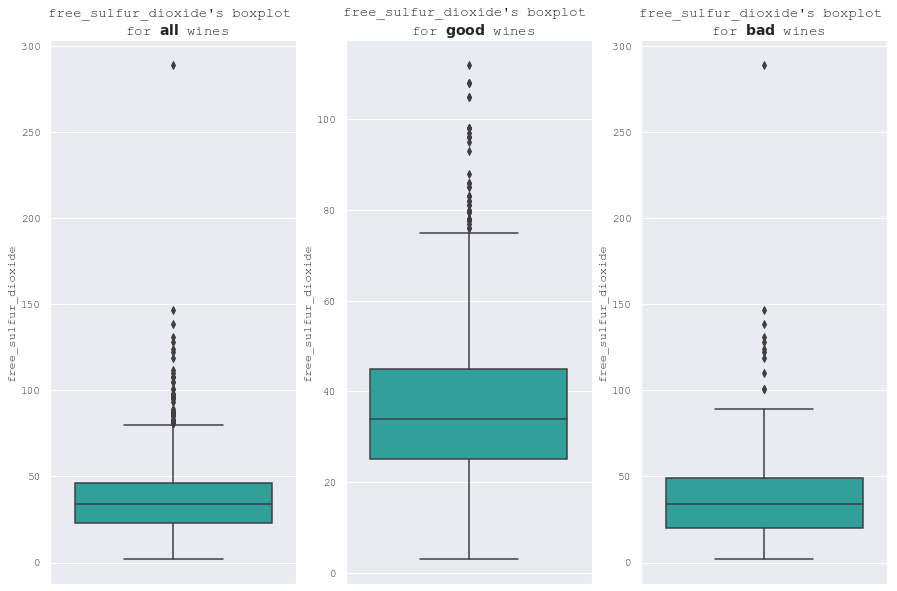

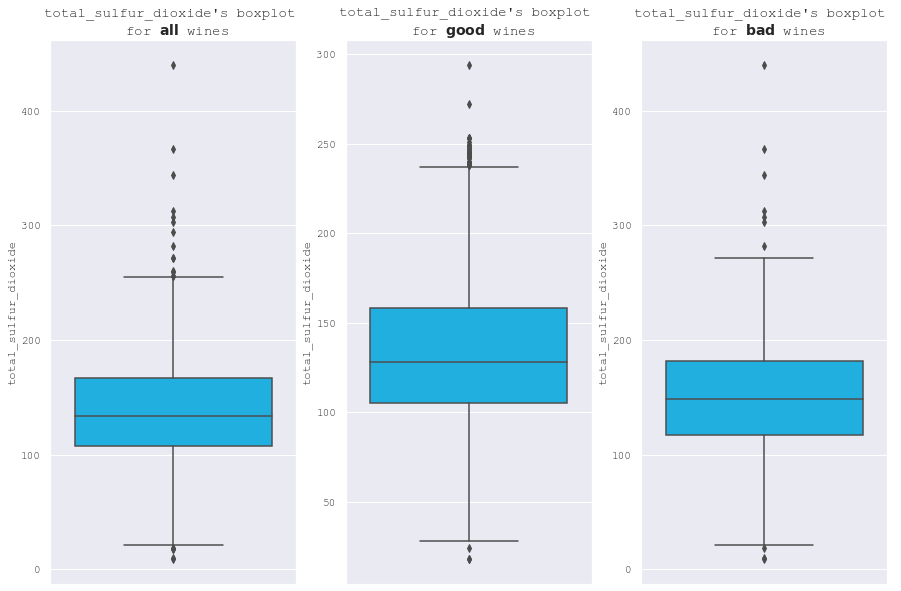

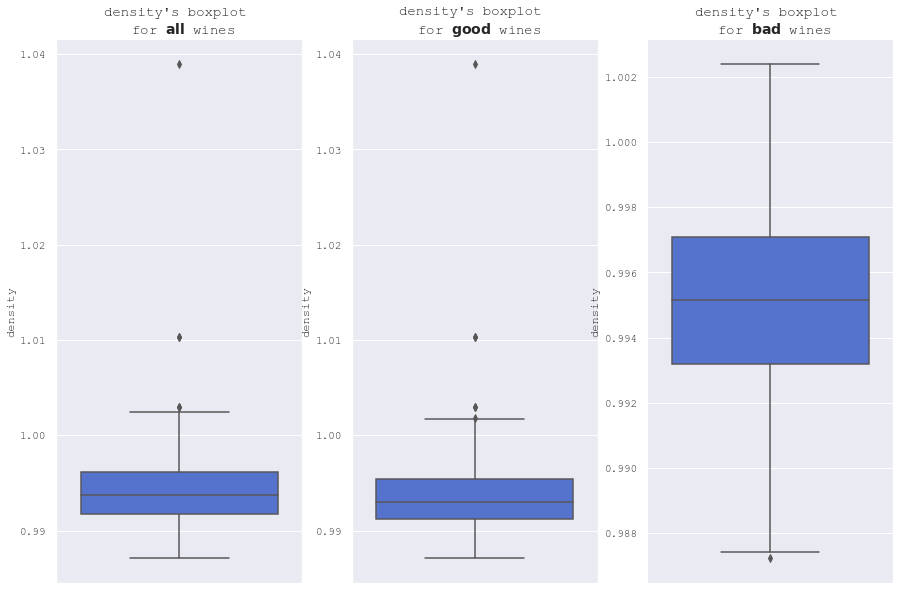

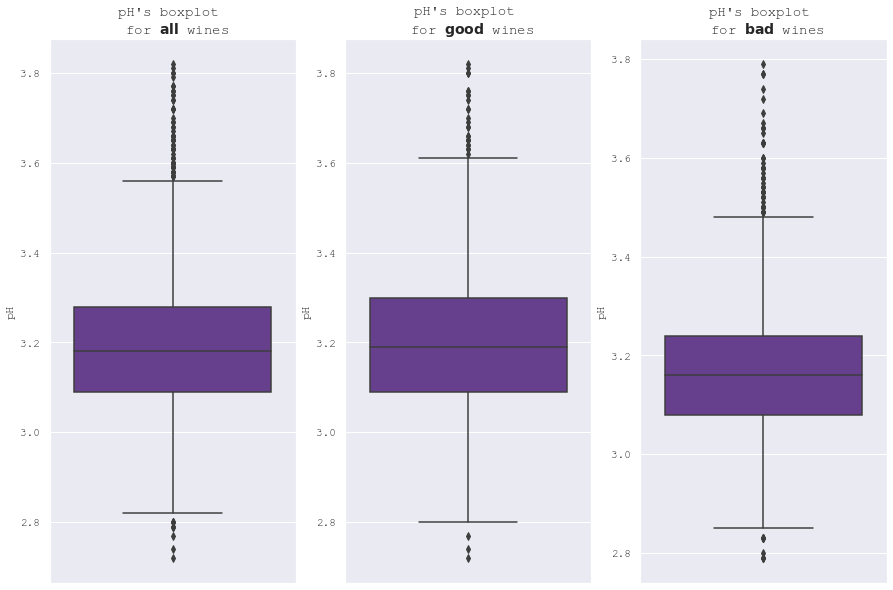

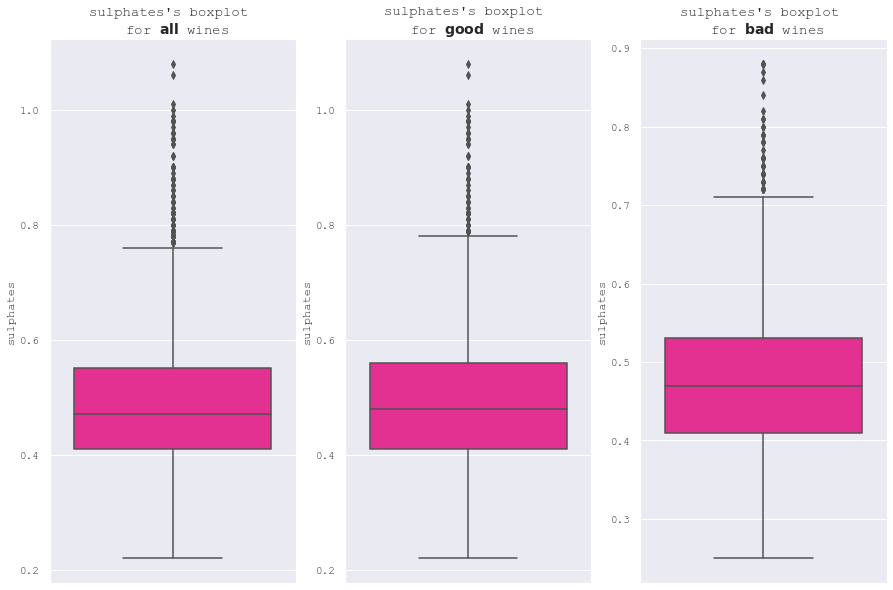

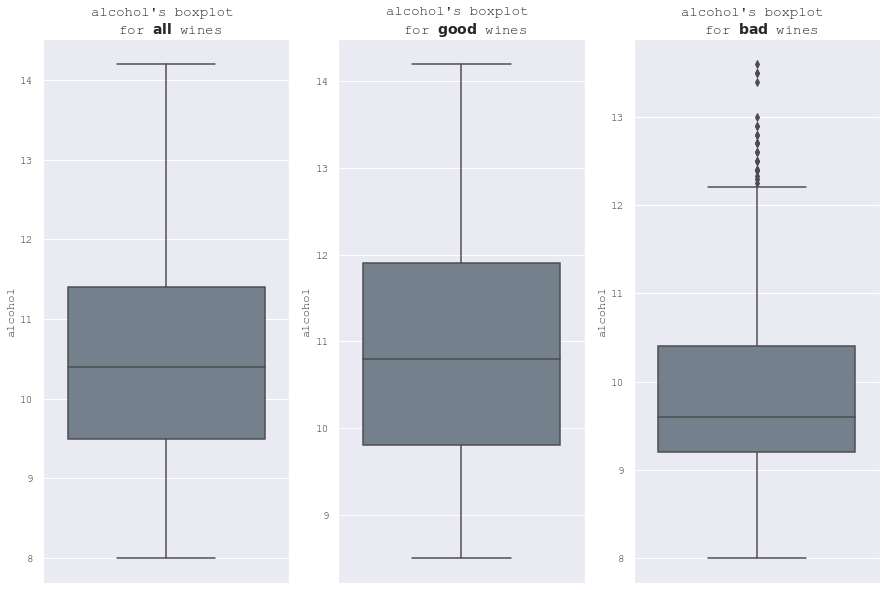

In [20]:
for var, col in zip(features,cmaps) :
    boxplots(x=var, color=col)

Almost all variables (except <i> alcohol </i>) are strugling with outliers.   
There are also some differences between good/bad wine groups, especially for <i> density </i>.

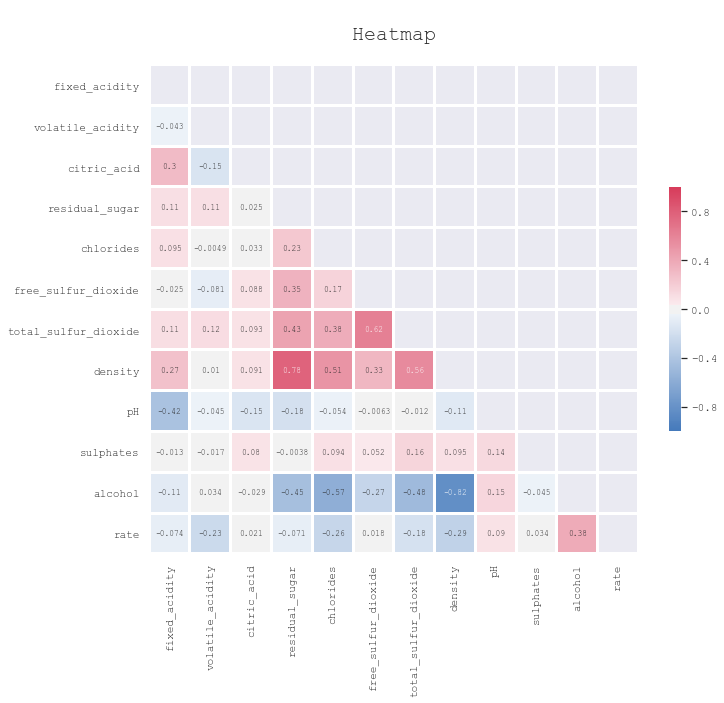

In [21]:
# Generating correlation plot

# Deleting uneccesery variable
df_corr_temp=df.copy()
df_corr=df_corr_temp.drop(columns='quality')

# Compute the correlation matrix
corr=df_corr.corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250,5, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, annot_kws={"size":8}, vmin=-1, vmax=1, center=0, square=True, linewidths=2, cbar_kws={"shrink": .5})
f.set_facecolor('w')
plt.title('\n Heatmap \n', fontsize=20)
plt.show()


Target variable is not highly correlated with any of features.  
It can be seen that <i>density</i> has strong <b>positive</b> correlation with <i>residual_sugar</i>.  
<i>density</i> is also has also stron <b>negative</b> correlation with <i>alcohol</i>.

In [22]:
# mutual information
minfos=[]

for var in features:
    print("Mutual info", var, feature_selection.mutual_info_classif(df[var].values.reshape(-1,1),df[target].values))
    minfos.append(feature_selection.mutual_info_classif(df[var].values.reshape(-1,1),df[target].values)[0])

imp = list(zip(minfos, features))
imp.sort(reverse=True)
imp

Mutual info fixed_acidity [0.01625154]
Mutual info volatile_acidity [0.03196056]
Mutual info citric_acid [0.0393681]
Mutual info residual_sugar [0.03226163]
Mutual info chlorides [0.03470712]
Mutual info free_sulfur_dioxide [0.04302965]
Mutual info total_sulfur_dioxide [0.04764228]
Mutual info density [0.08749286]
Mutual info pH [0]
Mutual info sulphates [0.00190525]
Mutual info alcohol [0.08413442]


[(0.10075341453391018, 'density'),
 (0.09022876929194656, 'alcohol'),
 (0.04182591215769538, 'citric_acid'),
 (0.04067426327733337, 'total_sulfur_dioxide'),
 (0.03993028923867392, 'residual_sugar'),
 (0.0348887356698695, 'chlorides'),
 (0.026535845649223955, 'free_sulfur_dioxide'),
 (0.02555582451557581, 'volatile_acidity'),
 (0.01116813088481794, 'pH'),
 (0.00863666910587746, 'fixed_acidity'),
 (0.0035136122082060073, 'sulphates')]

After calculating Mutual Information for each variable we can see quite low values of that measure

## 2.  Models

For setting a benchmark firstly I want to build as simple as possible Logistic Regression model 

### 2.1. Logistic Regression

In [22]:
# Connecting features into formula
"+".join(features)

'fixed_acidity+volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+density+pH+sulphates+alcohol'

In [23]:
# Wrapper for Logistic Regression w/ cross validation
def CVTest(nFolds = 5, randomState=2020, debug=False):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # To save some memory information about folds is only by row numbers
    testResults = []
    
    # For completness of the result we will add information about results on training data
    trainResults = []
    
    # We will keep also information about prediction on each fold
    predictions = []
    
    # With information about index in orginal dataset
    indices = []
    
    for train, test in kf.split(df.index.values):
        # GLM model estimation
        mod = sm.GLM.from_formula(formula="rate ~ fixed_acidity+volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+density+pH+sulphates+alcohol",
                                  data=df.iloc[train], family=sm.families.Binomial())
        res = mod.fit()
        predsTrain = res.predict()
        preds = res.predict(df.iloc[test])
        
        # Let's keep information about prediction for whole fold
        predictions.append(preds.tolist().copy())
        
        # with indices from orginal dataset
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Results on each fold
        trainScore = roc_auc_score(df[target].iloc[train]==1, predsTrain)
        testScore = roc_auc_score(df[target].iloc[test]==1, preds)
        
        # Saving result
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [24]:
# Saving results into variables
trainResults, testResults, predictions, indices = CVTest(nFolds = 5, randomState=2020)
print(np.mean(trainResults), np.mean(testResults))

0.8017420503530825 0.7988934672228089


In [25]:
# Results for each fold
print(trainResults)
print(testResults)

[0.7981850840973242, 0.8000961764284861, 0.8024551393336798, 0.8075013238247087, 0.8004725280812142]
[0.8113352272727273, 0.8047994713146918, 0.7985783466094429, 0.7761539120258042, 0.8036003788913784]


In [26]:
# Saving results history
Logit = {
    "name":"Logistic Regression",
    "description":"First simple model",
    "specification":"deposit ~ age+job+marital+education+default+balance+housing+loan+contact+day+month+duration+campaign+pdays+previous+poutcome",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

def plotROCs(results):
    ''' Function to plot ROC curves for experiment results - list results as a 3 elements tuples (true, pred, label)
    '''
    
    # Figure size
    fig, ax = plt.subplots(figsize=(7,6))
        
    for true, pred, label in results:
        # Calculating points needed to plot ROC curve
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Calculating area under the ROC curve
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)
        

        # Curve thickness
        lw = 2

        # Plot the curve
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    # 45 degrees curve as a reference
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # We add margins so that the curve does not overlap axes
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

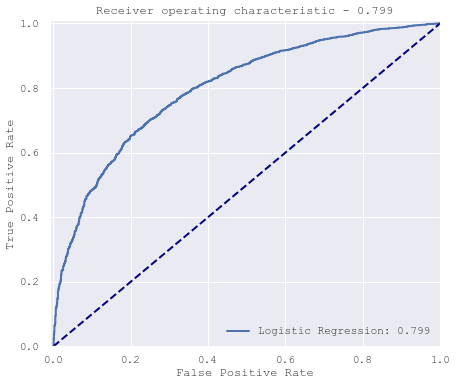

In [28]:
# Preparing data for drawing
# Sorting true data
true = (df.rate==1).sort_index()

# Prediction vector, sorting index
pred = pd.Series(sum(Logit["predictions"], []), index=sum(Logit["indices"], [])).sort_index()

# Plot
plotROCs([(true, pred, Logit["name"])])

Well, Logistic Regression sets a benchmark at 0.799 ROC AUC score. At the moment I am not going to try to correct it. It just a reference, what results we can get with sloppy Logit model.

### 2.2. SVM

Second model, that I am going to build, would use SVM algorithm

In [30]:
# Normalization of numerical features
df[features] = df[features].apply(lambda x: (x-x.mean())/x.std())

In [31]:
# Wrapper for SVM w/ cross validation
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVC

def CVTestSVM(nFolds = 5, randomState=2020, debug=False, sampleSize = 3000, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # To save some memory information about folds is only by row numbers
    testResults = []
    
    # For completness of the result we will add information about results on training data
    trainResults = []
    
    # We will keep also information about prediction on each fold
    predictions = []
    # With information about index in orginal dataset
    indices = []
    for train, test in kf.split(df.index.values):
        # Preparing estimator
        clf = SVC(probability=True, max_iter=-1, random_state=2020, tol=0.001, cache_size=500, *args, **kwargs)
        # Displaying the function call
        if debug:
            print(clf)
        # Reduction of training set
        sampleSize = sampleSize
        X = df.iloc[train].sample(sampleSize)
        # Training the model
        clf.fit(X[features], X[target])

        # Predictions for training and test sets
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Let's keep information about prediction for whole fold
        predictions.append(preds.tolist().copy())
        
        # with indices from orginal dataset
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Results on each fold
        trainScore = roc_auc_score(df[target].iloc[train]==1, predsTrain)
        testScore = roc_auc_score(df[target].iloc[test]==1, preds)
        
        # Saving result
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # We can also display information during validation
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [32]:
trainResults, testResults, predictions, indices = CVTestSVM(debug = False)
print(np.mean(testResults))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

0.830718244488887


Default settings gave us ROC AUC score=0.8307

##### kernel selection

Now, I will make some experiments to decide which type of kernel is proper for our data

In [33]:
# linear kernel
trainResults, testResults, predictions, indices = CVTestSVM(debug=True, kernel="linear")
print(np.mean(trainResults), np.mean(testResults))

SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)
Train AUC: 0.7924353232089952 Valid AUC: 0.7996496212121212
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)
Train AUC: 0.7982531867994913 Valid AUC: 0.8064217825689884
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)
Train AUC: 0.7986450692894684 Valid AUC: 0.7981855717508657
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ov

In [34]:
# Saving results
result_SVM_Lin = {
    "name":"SVM Lin",
    "description":"SVM model, default C=1, linear kernel",
    "specification":'kernel="linear"',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [35]:
# polynominal kernel, degree=2
trainResults, testResults, predictions, indices = CVTestSVM(debug=True, degree=2,kernel="poly")
print(np.mean(trainResults), np.mean(testResults))

SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.724484014509996 Valid AUC: 0.7269176136363636
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.7342067987211356 Valid AUC: 0.7033648617019812
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.7309183112257169 Valid AUC: 0.715075369663411
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.7428581914311696 Valid AUC: 0.695139820550148
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.7170202623152521 Valid AUC: 0.7099750441736342
0.729897515640654 0.7100945419451076


In [36]:
# Saving results
result_SVM_Poly = {
    "name":"SVM Poly 2",
    "description":"SVM model, default C=1, polynominal kernel 2. degree",
    "specification":'degree=2,kernel="poly"',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [37]:
# RBF kernel
trainResults, testResults, predictions, indices = CVTestSVM(debug=True, kernel="rbf",)
# wyświetlenie wyników dla zbioru treningowego i testowego
print(np.mean(trainResults), np.mean(testResults))

SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8585196654769403 Valid AUC: 0.8536979166666667
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8656422348556664 Valid AUC: 0.8296779700687016
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8653146056272116 Valid AUC: 0.8193714644275306
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8712013221353395 Valid AUC: 0.8097722147689321
SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8601140985314448 Valid AUC: 0.8492904894620835
0.8641583853253205 0.8323620110787828


In [38]:
result_SVM_RBF = {
    "name":"SVM RBF",
    "description":"SVM model, default C=1, RBF kernelem",
    "specification":'kernel="rbf",',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

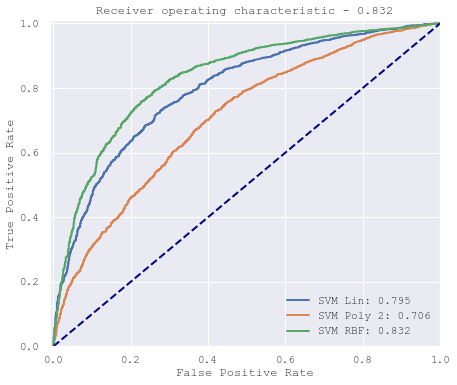

In [39]:
res2plot = []
true = (df[target]==1).sort_index()
for result in [result_SVM_Lin, result_SVM_Poly, result_SVM_RBF]:
    # Prediction vector, sorting index
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Plot
plotROCs(res2plot)

After displaying results it is clear and obvious that from tested kernel for our dataset RBF is the best ang give the best result

##### C selection

Using previously chosen kernel, I will look for proper value of C parameter

In [40]:
testCvalue = []
for c in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100]:
    trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel="rbf", C=c)
    print(c, np.mean(testResults))
    testCvalue.append(
        {
        "name":f"SVM RBF = {c}",
        "description":"Tests with C and RBF kernelem",
        "specification":'kernel="rbf" C=c,',
        "trainResults":trainResults.copy(),
        "testResults":testResults.copy(),
        "predictions":predictions.copy(),
        "indices":indices.copy(),
    }
    )

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

0.01 0.8138873183967551


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

0.1 0.8175589715841056


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

0.25 0.8241606675480725


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

0.5 0.8284081016505531


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

1 0.8318108435236832


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

2 0.8355857479717507


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

5 0.8299502824682244


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

10 0.8295697797067033


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

25 0.8204127308430055


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

50 0.8177852373166894


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

100 0.8049624133337876


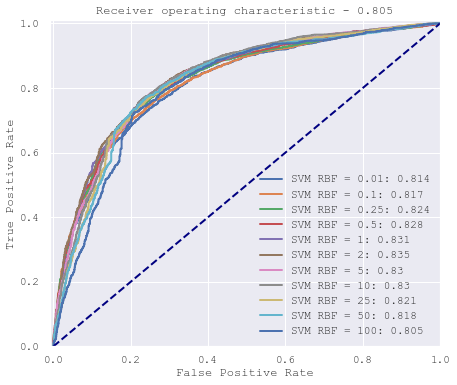

In [41]:
res2plot = []
true = (df[target]==1).sort_index()
for result in testCvalue:
    # Prediction vector, sorting index
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Plot
plotROCs(res2plot)

Looks like C in range(1,5) gives us the best result, so now I will look closely to that range

In [42]:
testCvalue = []
for c in [1, 2, 3, 4, 5]:
    trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel="rbf", C=c)
    print(c, np.mean(testResults))
    testCvalue.append(
        {
        "name":f"SVM RBF = {c}",
        "description":"Testy z C i kernelem RBF",
        "specification":'kernel="rbf" C=c,',
        "trainResults":trainResults.copy(),
        "testResults":testResults.copy(),
        "predictions":predictions.copy(),
        "indices":indices.copy(),
    }
    )

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

1 0.8322630736536315


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

2 0.8342940908983321


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

3 0.8313570847986963


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

4 0.8298906779951803


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

5 0.8298022977813793


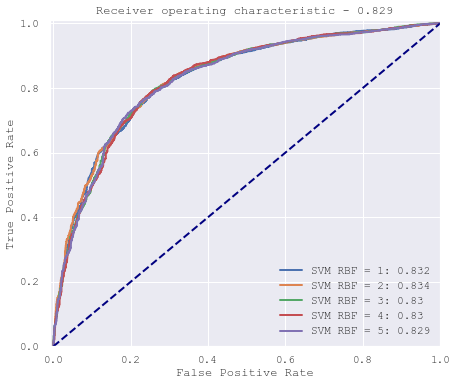

In [43]:
res2plot = []
true = (df[target]==1).sort_index()
for result in testCvalue:
    # Prediction vector, sorting index
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Plot
plotROCs(res2plot)

C=2 gives us the highest ROC AUC score

In [44]:
# RBF with C=2
trainResults, testResults, predictions, indices = CVTestSVM(debug=True, kernel="rbf", C=2)
# wyświetlenie wyników dla zbioru treningowego i testowego
print(np.mean(trainResults), np.mean(testResults))

SVC(C=2, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8720589264469172 Valid AUC: 0.8469744318181819
SVC(C=2, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8703440629426518 Valid AUC: 0.8320735753720762
SVC(C=2, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8771735213510798 Valid AUC: 0.8177117511531774
SVC(C=2, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8831550660397748 Valid AUC: 0.8116109572878905
SVC(C=2, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=2020,
    shrinking=True, tol=0.001, verbose=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train AUC: 0.8664287625173684 Valid AUC: 0.8436549356066816
0.8738320678595585 0.8304051302476015


In [45]:
# saving results
SVM = {
    "name":"SVM",
    "description":"SVM model, with C=2 and RBF kernel",
    "specification":'kernel="rbf",',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

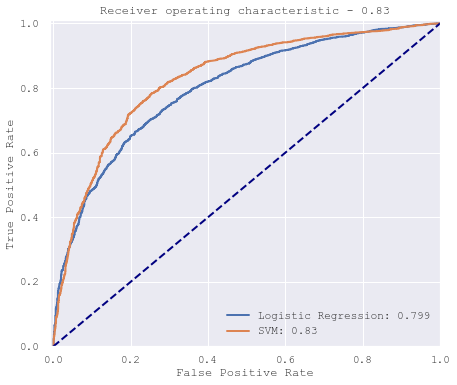

In [47]:
# Making plot to compare Logit and SVM results

res2plot = []
true = (df[target]==1).sort_index()
for result in [Logit, SVM]:
    # Prediction vector, sorting index
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Plot
plotROCs(res2plot)

As you can see, SVM model gives circa 0.03 better result than that sloppy Logistic Regression

### 2.3. kNN

Next model that I want to build will be using k nearest neighbour algorithm.

In [50]:
# Assinging columns to variables
df = df_o.copy()

target = "rate"

features = df.columns.tolist()
features.remove(target)
features.remove('quality')
features.remove('taste')
print(features)

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [51]:
# Wrapper for kNN w/ cross validation
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics import roc_auc_score

def CVTestKNN(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # To save some memory information about folds is only by row numbers
    testResults = []
    
    # For completness of the result we will add information about results on training data
    trainResults = []
    
    # We will keep also information about prediction on each fold
    predictions = []
    # With information about index in orginal dataset
    indices = []
    # Loop to walidate model on each fold
    for train, test in kf.split(df.index.values):
        # Preparing estimator
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Training the model
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Predictions for training and test sets
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Let's keep information about prediction for whole fold
        predictions.append(preds.tolist().copy())
        
        # with indices from orginal dataset
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Results on each fold
        trainScore = roc_auc_score(df[target].iloc[train]==1, predsTrain)
        testScore = roc_auc_score(df[target].iloc[test]==1, preds)
        
        # Saving result
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # We can also display information during validation
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [52]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=50, n_jobs=-1, p=2, debug=True)
print(np.mean(testResults))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
                     weights='uniform')
Train AUC: 0.7297240592996944 Valid AUC: 0.7484801136363637
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
                     weights='uniform')
Train AUC: 0.7410783282349833 Valid AUC: 0.6885621319969344
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
                     weights='uniform')
Train AUC: 0.7455271668173729 Valid AUC: 0.6715420245148992
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
                     weights='uniform')
Train AUC: 0.7359045436460201 Valid AUC: 0.7178422249498092
KNeighborsClassi

Default setting without normalization gave us ROC AUC score in region of 0.713

In [53]:
# Normalization of numerical features
df[features] = df[features].apply(lambda x: (x-x.mean())/x.std())

In [54]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=50, n_jobs=-1, p=2, debug=True)
print(np.mean(testResults))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
                     weights='uniform')
Train AUC: 0.8305608043483332 Valid AUC: 0.8379356060606061
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
                     weights='uniform')
Train AUC: 0.8346595804156339 Valid AUC: 0.8177940238367317
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
                     weights='uniform')
Train AUC: 0.8386893417216921 Valid AUC: 0.8086252400956071
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
                     weights='uniform')
Train AUC: 0.8382108530907011 Valid AUC: 0.7988468015870751
KNeighborsClassi

When we normalize our numerical features our result improve by 0.1 to ROC AUC score = 0.819

#### Hiperparameters' tunning 

Now look at some of the hiperparameters to chose better options

##### number of neighbors

In [55]:
# Cross validation for different number of neighbors
for k in [1, 3, 5, 10, 15, 30, 50, 100, 150, 200]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(testResults))

1 0.7753652560036366
3 0.809248945847264
5 0.8072625665727434
10 0.8161677057169262
15 0.8202464475028236
30 0.8217443316711341
50 0.8187668986091348
100 0.810260416441922
150 0.8061705212505463
200 0.8025247912738427


We should dig dipper in region of 15 to 50

In [56]:
# Close look in [15,50] range

for k in [15, 20, 25, 30, 35, 40, 45, 50]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(testResults))

15 0.8202464475028236
20 0.8235614772675351
25 0.8211328590043694
30 0.8217443316711341
35 0.8214972669604711
40 0.8202194011103867
45 0.819048949809579
50 0.8187668986091348


20 neighbors seems to gave the best result and be the proper one

##### distance measures

Now look which distance measure (manhattan or euclidean) perform better with our data

In [57]:
# Checking distance measure

for k in [1,2]:
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=20, n_jobs=-1, p=k)
    print(d, np.mean(testResults))

1 0.8254128504263424
2 0.8235614772675351


Manhattan distance (p=1) gives slightly better results than euclidean

#### Feature engineering

Now I want to check what can I do with features I have to improve performence of the algorithm

##### feature selection

I will estimate model for each feature separately

In [59]:
# I will progressively add new features, starting from empty list
selectedFeatures = []

# Next I will add each feature as a candidate
results = []
for feature in features:
    # cleaning list
    featuresCandidates = selectedFeatures.copy()
    # adding feature that we want to test
    featuresCandidates.append(feature)
    # model estimation
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=30, n_jobs=-1, p=1, features=featuresCandidates)
    print(feature, np.mean(testResults))
    # saving into results
    results.append((feature, np.mean(testResults)))

fixed_acidity 0.5408168337506942
volatile_acidity 0.6148532012391228
citric_acid 0.6264014097481371
residual_sugar 0.584780169501007
chlorides 0.6338989079987536
free_sulfur_dioxide 0.6000886551322484
total_sulfur_dioxide 0.6329879847204098
density 0.6814307466310471
pH 0.5266005675607158
sulphates 0.5321057297795393
alcohol 0.7199205509621593


In [60]:
# sorting results
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('alcohol', 0.7199205509621593),
 ('density', 0.6814307466310471),
 ('chlorides', 0.6338989079987536),
 ('total_sulfur_dioxide', 0.6329879847204098),
 ('citric_acid', 0.6264014097481371),
 ('volatile_acidity', 0.6148532012391228),
 ('free_sulfur_dioxide', 0.6000886551322484),
 ('residual_sugar', 0.584780169501007),
 ('fixed_acidity', 0.5408168337506942),
 ('sulphates', 0.5321057297795393),
 ('pH', 0.5266005675607158)]

Now I wil check if droping some of the least important features would improve ROC AUC score

In [61]:
for re in np.arange(0.52,0.62,0.01):
    featuresSet = [x for x,y in results if y > re]
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=20, n_jobs=-1, p=1, features=featuresSet)
    print( "{:.2f}".format(re), np.mean(testResults))

0.52 0.8254128504263424
0.53 0.8258239877446545
0.54 0.8254310651120772
0.55 0.8174395130669974
0.56 0.8174395130669974
0.57 0.8174395130669974
0.58 0.8174395130669974
0.59 0.8175605958601071
0.60 0.8175605958601071
0.61 0.8021485488753068


We get the best result when we drop the least important feature (pH) out of the model

In [62]:
# preparing feature set without pH feature
featuresSet = [x for x,y in results if y > 0.52]

##### feature generation

Next step is trying to manipulate each feature wage

In [63]:
# Backup of the dataset
dfCopy = df.copy()

In [64]:
# adding each feature as a candidate
results2 = []
for feature in featuresSet:
    df = dfCopy.copy()
    # Multiplying feature by 2
    df[feature]=df[feature]*2
    # validating model
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=20, n_jobs=-1, p=1, features=featuresSet)
    print(feature, np.mean(testResults))
    results2.append((feature, np.mean(testResults)))

alcohol 0.8244258908873121
density 0.823898912881137
chlorides 0.8239856855877964
total_sulfur_dioxide 0.8262338695193806
citric_acid 0.8242631135115346
volatile_acidity 0.8280493041191853
free_sulfur_dioxide 0.8268988284906131
residual_sugar 0.8246078986270338
fixed_acidity 0.8214214337449942
sulphates 0.8182210873560039
pH 0.8239959277414111


In [209]:
# Sorting
results2 = sorted(results2, key=lambda x: x[1], reverse=True)
results2

[('volatile_acidity', 0.8280493041191853),
 ('free_sulfur_dioxide', 0.8268988284906131),
 ('total_sulfur_dioxide', 0.8262338695193806),
 ('residual_sugar', 0.8246078986270338),
 ('alcohol', 0.8244258908873121),
 ('citric_acid', 0.8242631135115346),
 ('pH', 0.8239959277414111),
 ('chlorides', 0.8239856855877964),
 ('density', 0.823898912881137),
 ('fixed_acidity', 0.8214214337449942),
 ('sulphates', 0.8182210873560039)]

Increasing wage of the most important features

In [65]:
for k in [1.5, 2, 3, 4, 5]:
    df = dfCopy.copy()
    # multiply by k
    df["volatile_acidity"]=df["volatile_acidity"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=20, n_jobs=-1, p=1, features=featuresSet)
    print(k, np.mean(testResults))

1.5 0.8246877621737407
2 0.8280493041191853
3 0.8265613692904747
4 0.8244056918262019
5 0.8233461627342041


In [66]:
for k in [1, 1.5, 2, 3, 4, 5]:
    df = dfCopy.copy()
    
    # Looking for next best feature wage for existing set
    df["volatile_acidity"]=df["volatile_acidity"]*2
    # multiply by k
    df["free_sulfur_dioxide"]=df["free_sulfur_dioxide"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=20, n_jobs=-1, p=1, features=featuresSet)
    print(k, np.mean(testResults))

1 0.8280493041191853
1.5 0.8269466593819624
2 0.8264957078280191
3 0.8265375167404219
4 0.8244750773656069
5 0.8205249534123359


In [67]:
for k in [1, 1.5, 2, 3, 4, 5]:
    df = dfCopy.copy()
    
    # Looking for next best feature wage for existing set
    df["volatile_acidity"]=df["volatile_acidity"]*2
    # multiply by k
    df["total_sulfur_dioxide"]=df["total_sulfur_dioxide"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=20, n_jobs=-1, p=1, features=featuresSet)
    print(k, np.mean(testResults))

1 0.8280493041191853
1.5 0.8295583737875678
2 0.82932703421008
3 0.8279238184770898
4 0.8261846797514073
5 0.8256067296095152


Decreasing wage of the least important features

In [70]:
for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8, 1]:
    df = dfCopy.copy()
    
    # Looking for next best feature wage for existing set
    df["volatile_acidity"]=df["volatile_acidity"]*2
    df["total_sulfur_dioxide"]=df["total_sulfur_dioxide"]*1.5
    # multiply by k
    df["sulphates"]=df["sulphates"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=20, n_jobs=-1, p=1, features=featuresSet)
    print(k, np.mean(testResults))

0.1 0.8295264913053723
0.25 0.830929922282029
0.4 0.8315189966217427
0.5 0.8305140624258518
0.65 0.829621447141023
0.8 0.8295581103292535
1 0.8295583737875678


In [71]:
for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8, 1]:
    df = dfCopy.copy()
    
    # Looking for next best feature wage for existing set
    df["volatile_acidity"]=df["volatile_acidity"]*2
    df["total_sulfur_dioxide"]=df["total_sulfur_dioxide"]*1.5
    df["sulphates"]=df["sulphates"]*0.4
    # multiply by k
    df["fixed_acidity"]=df["fixed_acidity"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=20, n_jobs=-1, p=1, features=featuresSet)
    print(k, np.mean(testResults))

0.1 0.82823660831612
0.25 0.8280909779707356
0.4 0.8300680952842878
0.5 0.8310431376852041
0.65 0.8320234356936453
0.8 0.8316863356025447
1 0.8315189966217427


Now I will apply gained knowledge, save and compare results

In [73]:
df = dfCopy.copy()

# Applying gained knowledge
df["volatile_acidity"]=df["volatile_acidity"]*2
df["total_sulfur_dioxide"]=df["total_sulfur_dioxide"]*1.5
df["sulphates"]=df["sulphates"]*0.4
df["fixed_acidity"]=df["fixed_acidity"]*0.65
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=20, n_jobs=-1, p=1, features=featuresSet)
print(k, np.mean(testResults))

KNN = {
    "name":"KNN",
    "description":"KNN model, 20 neighbors, reduced number of modified features",
    "specification":'n_neighbors=20, n_jobs=-1, p=1, features=featuresSet',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

1 0.8320234356936453


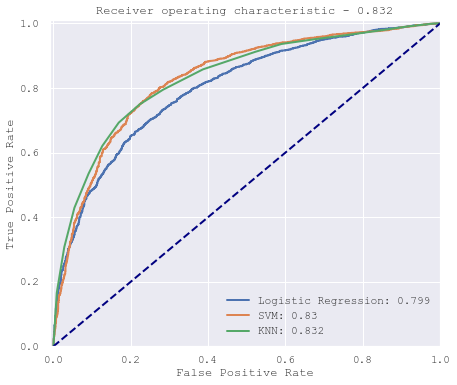

In [74]:
# Comparing results to previous algorithms

res2plot = []
true = (df[target]==1).sort_index()
for result in [Logit, SVM, KNN]:
    # Prediction vector, sorting index
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Plot
plotROCs(res2plot)

As of now, kNN perform very similar to SVM, although the kNN curve is smoothier than SVM one

### 2.4. Random Forest

It came time for one of the most efficient algorithm - Random Forest

In [78]:
# Assinging columns to variables
df = df_o.copy()

target = "rate"

features = df.columns.tolist()
features.remove(target)
features.remove('quality')
features.remove('taste')
print(features)

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [79]:
# Wrapper for Random Forest w/ cross validation
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


def CVTestRFClass(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # To save some memory information about folds is only by row numbers
    testResults = []
    
    # For completness of the result we will add information about results on training data
    trainResults = []
    
    # We will keep also information about prediction on each fold
    predictions = []
    # With information about index in orginal dataset
    indices = []
    # Loop to walidate model on each fold
    for train, test in kf.split(df.index.values):
        # Preparing estimator
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Training the model
        clf.fit(df.iloc[train][features], df.iloc[train][target])
        
        # Predictions for training and test sets
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Let's keep information about prediction for whole fold
        predictions.append(preds.tolist().copy())
        
        # with indices from orginal dataset
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Results on each fold
        trainScore = roc_auc_score(df[target].iloc[train]==1, predsTrain)
        testScore = roc_auc_score(df[target].iloc[test]==1, preds)
        
        # Saving result
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # We can also display information during validation
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [80]:
trainResults, testResults, predictions, indices = CVTestRFClass(debug=True)
print(np.mean(testResults))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train AUC: 0.9997107331980312 Valid AUC: 0.8841240530303031
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train AUC: 0.9995555661373141 Valid AUC: 0.8997861394499287
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train AUC: 0.9996171025028089 Valid AUC: 0.8698597985352372
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train AUC: 0.9996073672811117 Valid AUC: 0.8718684288147365
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train AUC: 0.9997361585629584 Valid AUC: 0.8807289105051278
0.8812734660670667


Default values gave us score in region of 0.88. Let see what we can do to improve it

#### Hiperparameters' tunning 

##### number of estimators

Default number of estimator in RF classificator is 100, let see how other numbers perform

In [81]:
# Pętla po parametrze n_estimators
for k in [10, 25, 50, 100, 200, 500, 1000]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

10 0.9996453855364449 0.8812734660670667 0.1183719194693782
25 0.9999953745197685 0.8992440200930345 0.100751354426734
50 0.9999999708400402 0.9035655537012465 0.09643441713879375
100 0.999999970606226 0.906462916640773 0.09353705396545298
200 1.0 0.9083102783048604 0.09168972169513956
500 1.0 0.9093900923546109 0.09060990764538912
1000 1.0 0.9101836433448527 0.08981635665514731


As anyone can imagine the more estimators the better the results is.  
Due to performence limitations for hiperparameters tunning I will use n_estimators=100

##### random search for optimal hiperparameters' values

Firstly I will random search on a wide range, then when I get my results I will narrow this range and one more time perform random search

In [82]:
# List for saving the results
results = []

In [83]:
import random
# Loop in which we will iterate through searches
for k in range(100):
    # Parameters' dictionary
    # For start I will chose wide ranges
    params = {
        "max_depth" : random.randint(2, 25),
        "max_features" : random.randint(2, 11),
        "min_samples_split" : random.randint(2, 9),
    }
    # min_samples_leaf must by lower than min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # Model estimation for drawn parameters
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100,
                                                                    max_depth=params["max_depth"],
                                                                    max_features=params["max_features"],
                                                                    min_samples_split=params["min_samples_split"],
                                                                    min_samples_leaf=params["min_samples_leaf"])
    
    # saving the result
    results.append((np.mean(testResults), params.copy()))
    
    # displaying result of current iteration
    print(params, np.mean(testResults))
    
    # after 10 iteration we will display top 5 from all previous searches
    if k>1 and k%10==0:    
        print("\n Top 5:")
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:5]:
            print(params, score)
        print()

{'max_depth': 24, 'max_features': 3, 'min_samples_split': 2, 'min_samples_leaf': 2} 0.8989974448257726
{'max_depth': 13, 'max_features': 2, 'min_samples_split': 3, 'min_samples_leaf': 3} 0.885206535940649
{'max_depth': 5, 'max_features': 7, 'min_samples_split': 9, 'min_samples_leaf': 1} 0.8284747483101427
{'max_depth': 2, 'max_features': 11, 'min_samples_split': 6, 'min_samples_leaf': 5} 0.7924430260430015
{'max_depth': 22, 'max_features': 4, 'min_samples_split': 4, 'min_samples_leaf': 2} 0.8986087885782306
{'max_depth': 11, 'max_features': 8, 'min_samples_split': 7, 'min_samples_leaf': 1} 0.8815294001237678
{'max_depth': 15, 'max_features': 3, 'min_samples_split': 3, 'min_samples_leaf': 1} 0.9017626391347779
{'max_depth': 9, 'max_features': 2, 'min_samples_split': 4, 'min_samples_leaf': 3} 0.8656682012435841
{'max_depth': 3, 'max_features': 11, 'min_samples_split': 4, 'min_samples_leaf': 4} 0.8050547154721144
{'max_depth': 18, 'max_features': 6, 'min_samples_split': 5, 'min_samples_le

{'max_depth': 9, 'max_features': 7, 'min_samples_split': 6, 'min_samples_leaf': 5} 0.86574844721824
{'max_depth': 21, 'max_features': 10, 'min_samples_split': 5, 'min_samples_leaf': 1} 0.8963460441919967
{'max_depth': 11, 'max_features': 10, 'min_samples_split': 2, 'min_samples_leaf': 2} 0.8836630228291085
{'max_depth': 2, 'max_features': 7, 'min_samples_split': 7, 'min_samples_leaf': 7} 0.793027325436643
{'max_depth': 14, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 1} 0.8983876547371491
{'max_depth': 5, 'max_features': 8, 'min_samples_split': 5, 'min_samples_leaf': 1} 0.8289128232308084

 Top 5:
{'max_depth': 15, 'max_features': 3, 'min_samples_split': 3, 'min_samples_leaf': 1} 0.9017626391347779
{'max_depth': 20, 'max_features': 10, 'min_samples_split': 2, 'min_samples_leaf': 1} 0.9013084247511672
{'max_depth': 22, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 1} 0.9005424597531612
{'max_depth': 19, 'max_features': 11, 'min_samples_split': 2, 'min

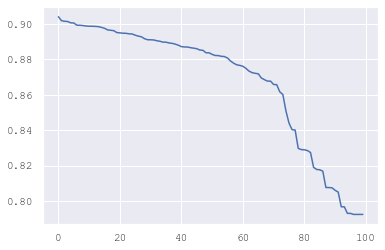

In [84]:
# Let see sorted results
plt.plot([x for x, y in sorted(results, key=lambda x: x[0], reverse=True)])

As you can see almost 15% of results are quite acceptable

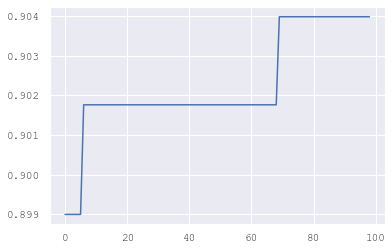

In [85]:
# We can see how best result get better with following iteration
bestHistory = []
for k in range(1,len(results)):
    # List comprehension: for k first values return maximum
    bestHistory.append(np.max([x for x, y in sorted(results[:k], key=lambda x: x[0], reverse=True)]))
# History plot
plt.plot(bestHistory)

As you can see after 70 iterations our best result has stopped to improve

Now, to narrow our search range I will look which values are reapeting in top 20 best iterations

In [86]:
# sorting and selecting top20 results
sortedResults=results.copy()
sortedResults.sort(key= lambda tup: tup[0], reverse=True)
for s in range(0,20):
    print(sortedResults[s])

(0.9039838956689262, {'max_depth': 22, 'max_features': 7, 'min_samples_split': 3, 'min_samples_leaf': 1})
(0.9017626391347779, {'max_depth': 15, 'max_features': 3, 'min_samples_split': 3, 'min_samples_leaf': 1})
(0.9014241136810256, {'max_depth': 17, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 1})
(0.9013084247511672, {'max_depth': 20, 'max_features': 10, 'min_samples_split': 2, 'min_samples_leaf': 1})
(0.9005424597531612, {'max_depth': 22, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 1})
(0.900470618340982, {'max_depth': 19, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 1})
(0.8992067376496683, {'max_depth': 20, 'max_features': 5, 'min_samples_split': 2, 'min_samples_leaf': 2})
(0.8991715862154143, {'max_depth': 18, 'max_features': 4, 'min_samples_split': 5, 'min_samples_leaf': 1})
(0.8989974448257726, {'max_depth': 24, 'max_features': 3, 'min_samples_split': 2, 'min_samples_leaf': 2})
(0.8987499542311509, {'max_depth': 25, 'max_

It look like we can narrow it to:  
        max_depth - (13, 25),  
        max_features - (2, 11),  
        min_samples_split - (2, 5),  

In [87]:
import random
# Loop in which we will iterate through searches
for k in range(100):
    # Parameters' dictionary
    # For start I will chose wide ranges
    params = {
        "max_depth" : random.randint(13, 25),
        "max_features" : random.randint(2, 11),
        "min_samples_split" : random.randint(2, 5),
    }
    # min_samples_leaf must by lower than min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # Model estimation for drawn parameters
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100,
                                                                    max_depth=params["max_depth"],
                                                                    max_features=params["max_features"],
                                                                    min_samples_split=params["min_samples_split"],
                                                                    min_samples_leaf=params["min_samples_leaf"])
    
    # saving the result
    results.append((np.mean(testResults), params.copy()))
    
    # displaying result of current iteration
    print(params, np.mean(testResults))
    
    # after 10 iteration we will display top 5 from all previous searches
    if k>1 and k%10==0:    
        print("\n Top 5:")
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:5]:
            print(params, score)
        print()

{'max_depth': 25, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 2} 0.8959278343303204
{'max_depth': 18, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 2} 0.8968863685653854
{'max_depth': 18, 'max_features': 4, 'min_samples_split': 2, 'min_samples_leaf': 2} 0.8981364229737517
{'max_depth': 21, 'max_features': 6, 'min_samples_split': 4, 'min_samples_leaf': 1} 0.8998871027442034
{'max_depth': 23, 'max_features': 5, 'min_samples_split': 3, 'min_samples_leaf': 2} 0.8995770973806
{'max_depth': 19, 'max_features': 9, 'min_samples_split': 2, 'min_samples_leaf': 1} 0.9012525789660751
{'max_depth': 13, 'max_features': 3, 'min_samples_split': 5, 'min_samples_leaf': 4} 0.88320666674696
{'max_depth': 24, 'max_features': 5, 'min_samples_split': 2, 'min_samples_leaf': 1} 0.9035743782866195
{'max_depth': 13, 'max_features': 6, 'min_samples_split': 5, 'min_samples_leaf': 1} 0.8942333126904775
{'max_depth': 22, 'max_features': 9, 'min_samples_split': 3, 'min_samples_lea

{'max_depth': 14, 'max_features': 10, 'min_samples_split': 4, 'min_samples_leaf': 2} 0.8926730610671385
{'max_depth': 14, 'max_features': 7, 'min_samples_split': 4, 'min_samples_leaf': 4} 0.8854854226914984
{'max_depth': 23, 'max_features': 9, 'min_samples_split': 2, 'min_samples_leaf': 2} 0.8965228919850988
{'max_depth': 21, 'max_features': 8, 'min_samples_split': 4, 'min_samples_leaf': 1} 0.8995461767113906
{'max_depth': 25, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 3} 0.8936445249401483
{'max_depth': 16, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 2} 0.8974272240769186

 Top 5:
{'max_depth': 22, 'max_features': 3, 'min_samples_split': 2, 'min_samples_leaf': 1} 0.9065636673821533
{'max_depth': 18, 'max_features': 4, 'min_samples_split': 2, 'min_samples_leaf': 1} 0.9053069302112158
{'max_depth': 22, 'max_features': 7, 'min_samples_split': 3, 'min_samples_leaf': 1} 0.9039838956689262
{'max_depth': 24, 'max_features': 6, 'min_samples_split': 2, 'm

It seems that we get the best ROC AUC score for:  
<b>max_depth</b>=20, <b>max_features</b>=2, <b>min_samples_split</b>=2, <b>min_samples_leaf</b>=1  
ROC AUC score = 0.9092758096782638

Now to my best model I will switch to n_estimators=1000, because time isn't as important as previously

In [88]:
import time
t0 = time.time()

trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000,max_depth=20, max_features=2, min_samples_split=2, min_samples_leaf=1, features=features, debug=True)
print(np.mean(testResults))

RF = {
    "name":"RF",
    "description":"RF, with max depth = 20, max features = 2, min samples split = 2 and min samples leaf = 1",
    "specification":'max_depth=20, max_features=2, min_samples_split=2, min_samples_leaf=1, features=features',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

t1=time.time()
total=t1-t0
print(total)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)
Train AUC: 1.0 Valid AUC: 0.9168702651515152
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_st

To compare results from Logit, SVM, kNN and RF I will one more time use plot

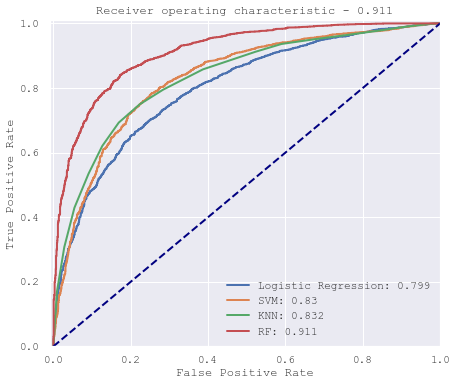

In [89]:
res2plot = []
true = (df[target]==1).sort_index()
for result in [Logit, SVM, KNN, RF]:
    # Prediction vector, sorting index
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Plot
plotROCs(res2plot)

As you can see Random Forest is extremely eficient and outperform other algorithms by almost 0.1

# XGBoost

Another gold standard for machine learning is XGBoost, so it woould be very informative to look how it work with this dataset

In [23]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
import time
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import gc

### 3.2. Wrapper dla XGBoost

In [24]:
def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2020, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja
    '''
    Uniwersalny wrapper dla XGB dla gbtree i dart
    Więcej opcji https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    Parametry
    ----------
    train, validate, features, target : wymagane zmienne bez domyślnych wartości
    train, validate : pd.DataFrames z kolumnami opisanymi w features i target
    features : lista zmiennych do wykorzystania w trenowaniu
    target : nazwa zmiennej objasnianej
    
    --- Zmienne wspólne dla gbtree i dart
        --- Zmienne właściwe dla Ensamble/Boosting
        eta : "learning rate"
        max_depth=7 : maksymalna głębokość drzew [0,∞]
        subsample : udział (0,1] obserwacji do treningu jednej iteracji
        colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
        colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji
        --- Zmienne regularyzacyjne
        lambdaX=0 : regularyzacja L2 [0,∞]
        alpha=0 : regularyzacja L1 [0,∞]
        gamma=1 : minimalna redukcja funkcji straty
        min_child_weight=0 : minimalna suma wg poddrzewa

    --- Zmienne dla algorytmu dart
    rate_drop : 
    skip_drop : 
    
    --- Zmienne dla XGB, opis/agorytm/liczba drzew etc.
    num_boost_round : maksymalna liczba iteracji
    early_stopping_rounds : margines iteracji dla early stopping
    debug : Czy włączyć pełne opisy.
    eval_metric : Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    objective : reg:linear, reg:logistic, binary:logistic, multi:softmax lub inne Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    seed : random seed
    booster : ‘auto’, ‘exact’, ‘approx’, ‘hist’, ‘gpu_exact’, ‘gpu_hist’- silnik dla drzew gbtree (cart), dart (gbtree z dropoutem) lub gblinear
    tree_method : zobacz http://xgboost.readthedocs.io/en/latest/parameter.html
    grow_policy : depthwise, lossguide
    '''
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        impFig.set_facecolor('w')
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [25]:
test_size = 0.2
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=2020, stratify=df[target].values)

First training

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2020, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 3918
Length valid: 980
[0]	train-auc:0.839475	valid-auc:0.798219
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.876624	valid-auc:0.817833
[2]	train-auc:0.890638	valid-auc:0.830054
[3]	train-auc:0.893977	valid-auc:0.831162
[4]	train-auc:0.898888	valid-auc:0.837465
[5]	train-auc:0.903979	valid-auc:0.842352
[6]	train-auc:0.906022	valid-auc:0.841786
[7]	train-auc:0.907318	valid-auc:0.841178
[8]	train-auc:0.909503	valid-auc:0.8418
[9]	train-auc:0.908616	valid-auc:0.84183
[10]	train-auc:0.909379	valid-auc:0.844278
[11]	train-auc:0.911119	valid-auc:

[179]	train-auc:0.982329	valid-auc:0.879741
[180]	train-auc:0.982496	valid-auc:0.879713
[181]	train-auc:0.982605	valid-auc:0.879938
[182]	train-auc:0.982838	valid-auc:0.880134
[183]	train-auc:0.982998	valid-auc:0.880106
[184]	train-auc:0.983253	valid-auc:0.880078
[185]	train-auc:0.983402	valid-auc:0.8802
[186]	train-auc:0.983459	valid-auc:0.880228
[187]	train-auc:0.983795	valid-auc:0.88063
[188]	train-auc:0.983896	valid-auc:0.880658
[189]	train-auc:0.983991	valid-auc:0.880733
[190]	train-auc:0.984213	valid-auc:0.880658
[191]	train-auc:0.984355	valid-auc:0.880602
[192]	train-auc:0.984488	valid-auc:0.880742
[193]	train-auc:0.984578	valid-auc:0.88077
[194]	train-auc:0.98474	valid-auc:0.881182
[195]	train-auc:0.984941	valid-auc:0.881154
[196]	train-auc:0.98508	valid-auc:0.881121
[197]	train-auc:0.985157	valid-auc:0.881229
[198]	train-auc:0.985406	valid-auc:0.881205
[199]	train-auc:0.985626	valid-auc:0.881383
[200]	train-auc:0.985908	valid-auc:0.881635
[201]	train-auc:0.986102	valid-auc:0.8

[367]	train-auc:0.99825	valid-auc:0.891287
[368]	train-auc:0.998271	valid-auc:0.891361
[369]	train-auc:0.998303	valid-auc:0.891394
[370]	train-auc:0.998329	valid-auc:0.89138
[371]	train-auc:0.998357	valid-auc:0.891637
[372]	train-auc:0.998379	valid-auc:0.891689
[373]	train-auc:0.998413	valid-auc:0.891796
[374]	train-auc:0.99844	valid-auc:0.891843
[375]	train-auc:0.998445	valid-auc:0.892002
[376]	train-auc:0.998462	valid-auc:0.892035
[377]	train-auc:0.998479	valid-auc:0.892002
[378]	train-auc:0.998509	valid-auc:0.891792
[379]	train-auc:0.998515	valid-auc:0.891656
[380]	train-auc:0.998518	valid-auc:0.891712
[381]	train-auc:0.998533	valid-auc:0.891848
[382]	train-auc:0.998556	valid-auc:0.891764
[383]	train-auc:0.998578	valid-auc:0.89181
[384]	train-auc:0.998576	valid-auc:0.891885
[385]	train-auc:0.998608	valid-auc:0.891941
[386]	train-auc:0.998634	valid-auc:0.891965
[387]	train-auc:0.998651	valid-auc:0.891974
[388]	train-auc:0.998673	valid-auc:0.892086
[389]	train-auc:0.998697	valid-auc:0

[555]	train-auc:0.999915	valid-auc:0.896491
[556]	train-auc:0.999917	valid-auc:0.896482
[557]	train-auc:0.999921	valid-auc:0.896631
[558]	train-auc:0.999924	valid-auc:0.89679
[559]	train-auc:0.999926	valid-auc:0.896739
[560]	train-auc:0.999925	valid-auc:0.896659
[561]	train-auc:0.999927	valid-auc:0.896472
[562]	train-auc:0.999927	valid-auc:0.896622
[563]	train-auc:0.999928	valid-auc:0.896627
[564]	train-auc:0.999929	valid-auc:0.896846
[565]	train-auc:0.99993	valid-auc:0.896725
[566]	train-auc:0.999932	valid-auc:0.896898
[567]	train-auc:0.999932	valid-auc:0.896809
[568]	train-auc:0.999934	valid-auc:0.89673
[569]	train-auc:0.999936	valid-auc:0.89679
[570]	train-auc:0.999939	valid-auc:0.896814
[571]	train-auc:0.999939	valid-auc:0.8968
[572]	train-auc:0.999942	valid-auc:0.896828
[573]	train-auc:0.999944	valid-auc:0.89694
[574]	train-auc:0.999944	valid-auc:0.896991
[575]	train-auc:0.999947	valid-auc:0.897057
[576]	train-auc:0.999949	valid-auc:0.897066
[577]	train-auc:0.99995	valid-auc:0.897

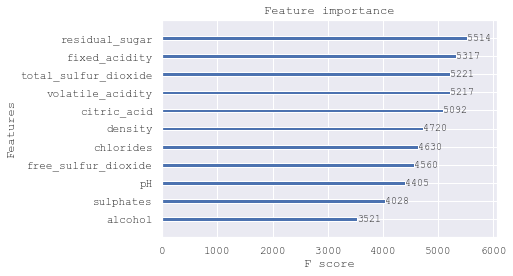

In [97]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, early_stopping_rounds=50)

First training gives us quite good results, ROC AUC score=0.8982

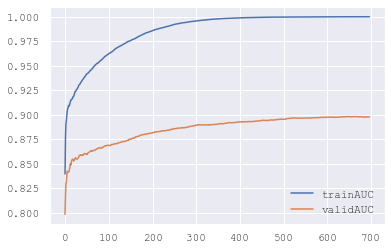

In [101]:
train_history.plot()
plt.show()

We can see how results has changed during trainig

#### Hiperparameters' tunning

At this point I am going to do some experiments with hiperparameters, for now without cross validation

##### max_depth

Firstly let us have a look at max_depth

4 0.875837
6 0.895472
8 0.900213
10 0.906344
12 0.911707
14 0.910374


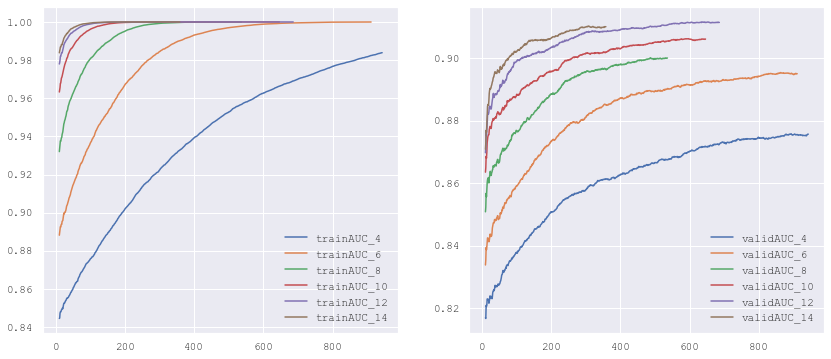

In [102]:
# Creating object for results
resHists = dict()
rang = range(4,15,2)
# Testing hiperparameters' values
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=x, early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Results history after first 10 observations
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

It looks like 12 is optimal value

##### subsample, colsample_bytree, colsample_bylevel

Now have a look at subsampling, both in row and in columns

First, some experiments to search for proper value of sub_sample

0.3 0.902958
0.4 0.906825
0.5 0.907199
0.6 0.909687
0.7 0.911707
0.8 0.912404
0.9 0.912455
1.0 0.906951


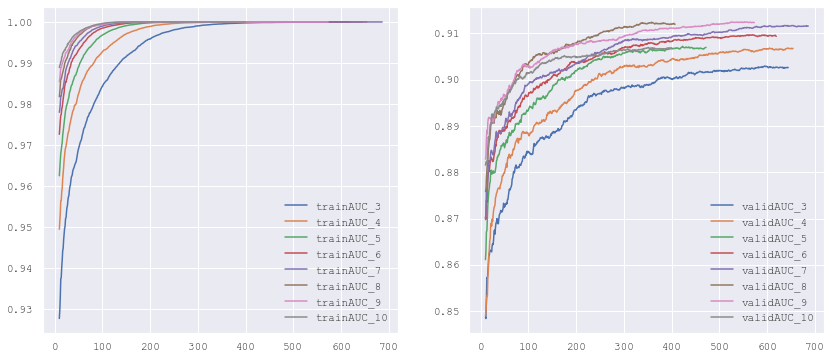

In [103]:
# sub_sample

resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=12,  subsample=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Results history after first 10 observations
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Values in region of 0.7 to 0.9 gives us the best results, well I will go with 0.8 in the next steps

Colsample_bytree is next in line to be tested

0.3 0.908102
0.4 0.90957
0.5 0.9134
0.6 0.912521
0.7 0.912404
0.8 0.913704
0.9 0.911791
1.0 0.911272


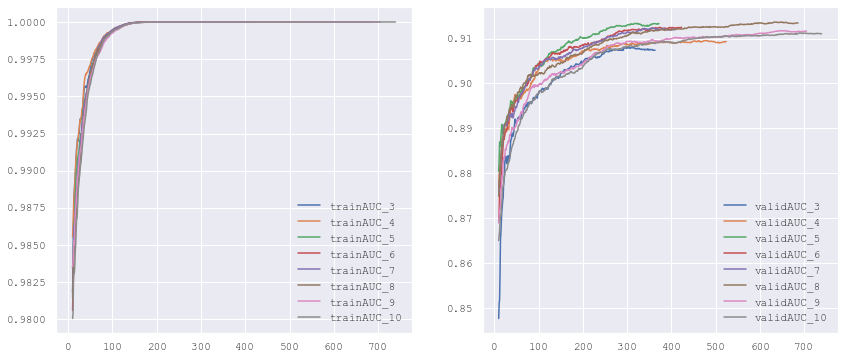

In [104]:
# colsample_bytree

resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=12, subsample=0.8, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Results history after first 10 observations
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Values of 0.8 and 0.5 gives almost the same results, but looking at plot I will go with 0.8

Now, first I will test values for colsample_bylevel with value of colsample_bytree=0.8 and then with default equal 1

0.3 0.909299
0.4 0.91108
0.5 0.909243
0.6 0.909243
0.7 0.912081
0.8 0.911618
0.9 0.911281
1.0 0.913704


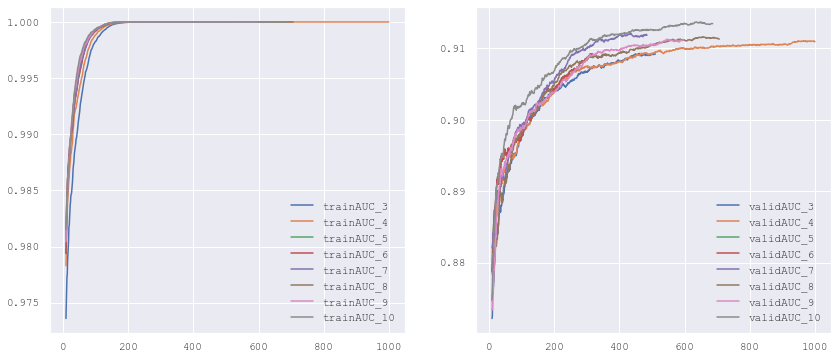

In [105]:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=12, subsample=0.8, colsample_bytree=0.8, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Results history after first 10 observations
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

0.3 0.909439
0.4 0.910543
0.5 0.909514
0.6 0.91347
0.7 0.912628
0.8 0.911146
0.9 0.911861
1.0 0.911272


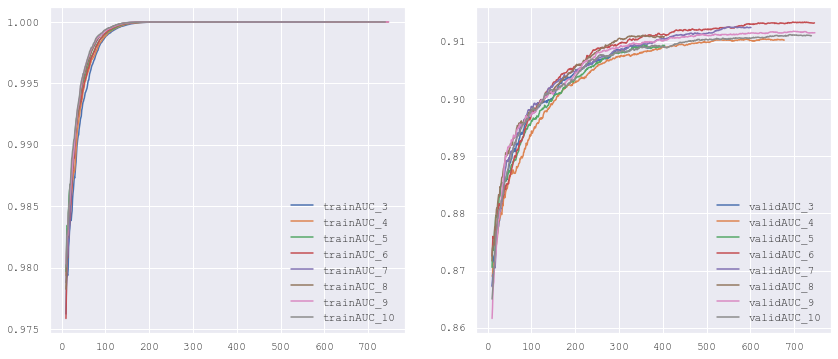

In [106]:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=12, subsample=0.8, colsample_bytree=1, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Results history after first 10 observations
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

So now I can tell that value o colsample_bylevel is not improving performance when colsample_bytree is equal to 0.7. When it is set as default = 1, then for colsample_bylevel=0.5 I get quite good results, but I will stay with max_depth=12, subsample=0.8, colsample_bytree=0.8

#### Regularization

Now I want to check whether changing regularization parameters would be beneficial 

##### lambda

0 0.909187
1 0.913704
4 0.910561
9 0.905123
16 0.903337
25 0.900971
36 0.898137
49 0.895215


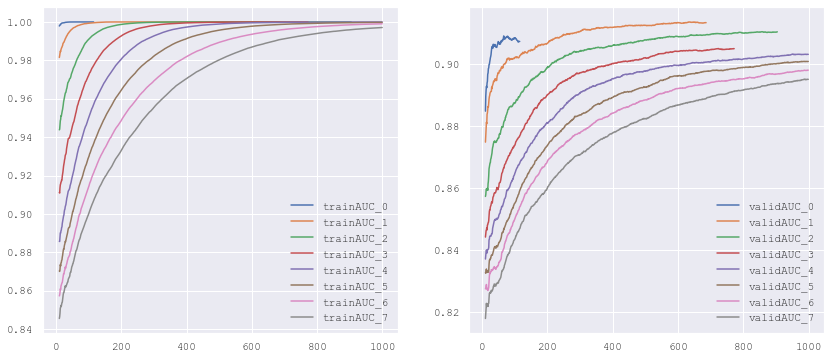

In [107]:
resHists = dict()

rang = range(0,8)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=x**2,
                                                          max_depth=12, subsample=0.8, colsample_bytree=0.8,
                                                          early_stopping_rounds=50, debug=False)
    
    print(x**2, score)
    resHists[x]=train_history
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Results history after first 10 observations
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Looking at those results it is rather obvious that lambda should stay at default value (lambdaX=1)

##### gamma

0 0.913704
0.01 0.91245
0.1 0.909542
0.5 0.907648
1 0.902013
2 0.894373
5 0.876674


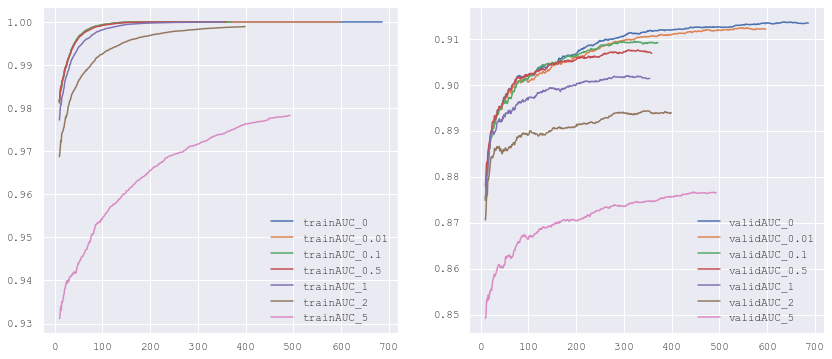

In [110]:
resHists = dict()
rang = [0, 0.01, 0.1, 0.5, 1, 2, 5]
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=1,
                                                          max_depth=12, subsample=0.8, colsample_bytree=0.8,
                                                          gamma=x,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Results history after first 10 observations
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

As for now it seems that here I also should keep default value (gamma=0), but I will decide after cross validation in next steps

#### Hiperparameters w/ cross validation

I will need cross validation wrapper for XGBoost algorithm

In [27]:
# Wrapper for XGB w/ cross validation
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


def CVTestXGB(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Saving results from both training and test sets
    testResults = []
    trainResults = []
    
    # We will keep also information about prediction on each fold
    predictions = []
    
    # With information about index in orginal dataset
    indices = []
    
    # Preparing histories list
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Preparing estimator
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Let's keep information about prediction for whole fold
        predictions.append(testPred.tolist().copy())
        
        # with indices from orginal dataset
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Results on each fold
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        # Saving resuls
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        # We can also display information during validation
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

Now look how good the perfomance will be for values of hiperparameters which we get from previous experiments

In [112]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
    max_depth=12, lambdaX=1, subsample=0.8, colsample_bytree=0.8, debug=False)
np.mean(trainResults), np.mean(testResults)

(1.0, 0.9063884412350471)

So, the results is slightly worse than previously, but it isn't a surprise

In next steps I will now perform previous experiments with cross validationt o check how stable the results are

##### max_depth

4 0.8735809818897646
5 0.8828531124286163
6 0.8908414682849133
7 0.8952553891650563
8 0.8983443038674593
9 0.9009142974064079
10 0.9036420168951993
11 0.9055396549462886
12 0.9064094509578794
13 0.9068552870634233
14 0.9076545708552368
15 0.9056747816306402
16 0.9070756971972775


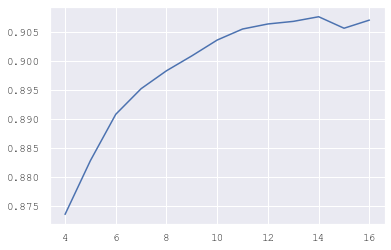

In [114]:
# max_depth

rang = range(4,17)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

max_depth=14 gives the best result and will be used in the next steps

##### subsample

2 0.8925421215200349
3 0.8992202806913674
4 0.9023660972272985
5 0.9039890724091307
6 0.9052354137251678
7 0.9076545708552368
8 0.9081343357931745
9 0.907614796254012
10 0.9086068460351295


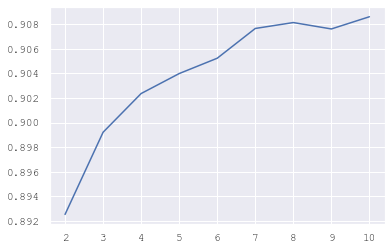

In [115]:
# subsample

rang = range(2,11)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=14, subsample = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

As with experiment without cross validation it turn out that the best value for subsample is 0.8

##### colsample_bytree

2 0.896421940518475
3 0.9076276417999598
4 0.9091391892754833
5 0.9093210210950394
6 0.909611091980046
7 0.9081343357931745
8 0.9071726688109394
9 0.9069087313177302
10 0.9056678416028252


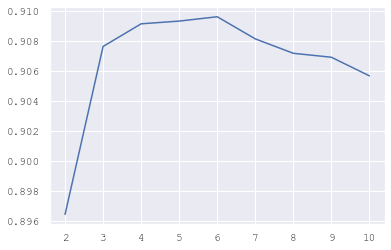

In [116]:
# colsample_bytree

rang = range(2,11)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=14, subsample = 0.8, colsample_bytree = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

This time results are slightly different and I get the best result for colsample_bytree=0.6

##### lambda

0 0.9130762930824267
1 0.909611091980046
4 0.9043697696371471
9 0.9020470339625575
16 0.8981173553649487
25 0.8950482586193337
36 0.8911871413469319
49 0.8880152323300706


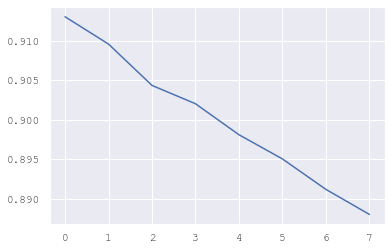

In [117]:
# lambda

rang = range(0,8)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=14, subsample = 0.8, colsample_bytree = 0.6, lambdaX=x**2)
    print(x**2, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Have a closer look at values 0 and 1

0 0.9144
1 0.91239


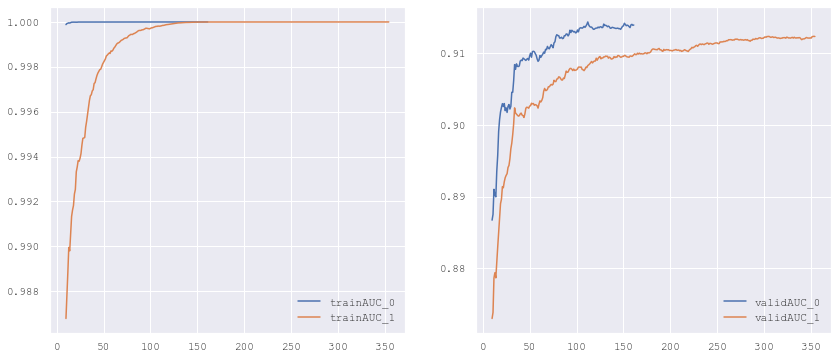

In [120]:
resHists = dict()

rang = range(0,2)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=x**2,
                                                          max_depth=14, subsample=0.8, colsample_bytree=0.6,
                                                          early_stopping_rounds=50, debug=False)
    
    print(x**2, score)
    resHists[x]=train_history
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Results history after first 10 observations
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

For lambda=1 the curve is smoothier, so I decide to stick with it

##### gamma

0 0.909611091980046
0.01 0.9098491060715841
0.1 0.9073605791469793
0.5 0.9043079462443494
1 0.9008480682264164
2 0.8938535880790817
4 0.8820990064691003
6 0.8704839811777866
8 0.8634195103743775
10 0.8518849387069514
15 0.8387734045626104


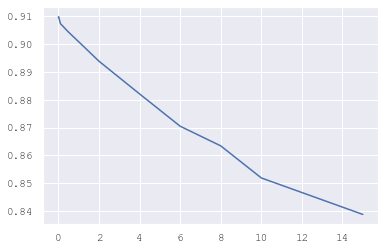

In [121]:
# gamma

rang = [0, 0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=14, subsample = 0.8, colsample_bytree = 0.6, lambdaX=1, gamma=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Against the results from previous experiment now tiny value of gamma improve our model 

#### Results

In [128]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=14, subsample = 0.8, colsample_bytree = 0.6, lambdaX=1, gamma=0.01)
print(np.mean(testResults))

XGB = {
    "name":"XGB",
    "description":"XGB model",
    "specification":'max_depth=14, subsample = 0.8, colsample_bytree = 0.6, lambdaX=1, gamma=0.01',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9098491060715841


With values of hiperparameters that have been found, I got circa 0.91, so very, very similar to Random Forest model

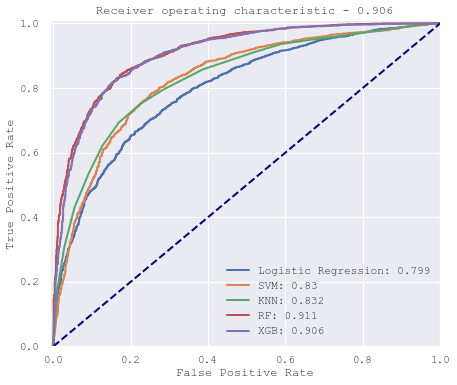

In [127]:
res2plot = []
true = df[target].sort_index()
for result in [Logit, SVM, KNN, RF, XGB]:
    # Prediction vector, sorting index
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Plot
plotROCs(res2plot)

Now it can be seen that, XGBoost and RF outclassed other algorithms and perform decisively better than others

#### Random search

As you can imagine such type of looking for optimal hiperparameters might cause some problems and some optimal values might be omitted, well in the end I want to execute random search for those values to check if better sets can be found

In [28]:
import random
import time
t0 = time.time()

results=[]
paramList = []
for x in range(1000):
    t0a=time.time()
    
    params = (random.randint(3, 16), random.uniform(0.1, 0.9), random.uniform(0.1, 0.9), random.uniform(0, 10), random.uniform(0, 10))
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        lambdaX=params[3],
        gamma=params[4])
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)
    
    t1a=time.time()
    totala = t1a-t0a
    print(totala)
    
t1 = time.time()

total = t1-t0
print('Training time: {} minutes'.format(round((total)/60, 2)))

0.8924425402911258 (15, 0.8104155278663513, 0.44422328441708026, 9.085178886417024, 0.3452195135135727)
32.10990595817566
0.8551291329362158 (8, 0.6648602773123435, 0.7509463151848021, 3.2423785834643515, 6.848610021958425)
28.38312315940857
0.8619848739650745 (13, 0.49093982312806206, 0.7446451769882548, 2.8273273416938762, 5.073356727227907)
33.35425567626953
0.8488926560317891 (10, 0.7447801403886198, 0.7070436627852071, 5.706048933385377, 8.244438250209257)
34.907610177993774
0.8337593883655174 (8, 0.18186223439374258, 0.4063770663970815, 1.4797364013955094, 8.198313286345382)
16.02478790283203
0.8510221531896415 (4, 0.704073785193547, 0.47509411030502025, 7.175822939114564, 4.150391527412393)
18.590108156204224
0.8341317438763592 (5, 0.5870553481626071, 0.7260893783354843, 9.573455824189285, 8.454130893260293)
13.031681060791016
0.869940922472248 (8, 0.5159634746215346, 0.2182329582602617, 5.583809601355272, 0.7132571150438871)
28.022201776504517
0.8566548775091316 (7, 0.764848332

0.8177937594758722 (16, 0.15376572972926025, 0.24349798036566794, 5.13352028677347, 7.995981198776992)
13.919450759887695
0.8431628538579895 (15, 0.568038477547217, 0.807480467731935, 9.351535714640313, 7.456695716998794)
33.296408891677856
0.8449296810743716 (8, 0.839421673386369, 0.35944580369829227, 5.621000726242084, 6.974253945328459)
11.184792757034302
0.8773071524579914 (5, 0.790702199482443, 0.3672766650784315, 4.389199851363936, 0.061625970831754584)
20.75348401069641
0.8282329646771582 (16, 0.14746925083255338, 0.8199620209854022, 7.261783650500586, 6.733660251616658)
18.224509239196777
0.8329747148763996 (9, 0.8964448581826785, 0.23317352933553848, 8.604630217512275, 8.816909695700115)
18.898492097854614
0.8314593547248308 (3, 0.10564118258639549, 0.48929048581948764, 5.359970362861034, 3.9849163582149085)
7.5787880420684814
0.8446295842466022 (4, 0.7118046384480973, 0.5940500758187113, 9.037120483541324, 5.732572366448677)
15.714674949645996
0.8068244633681679 (3, 0.1201252

0.8445480869915161 (3, 0.13602957807271424, 0.708822518268552, 0.4776746188769043, 0.8584657912683125)
6.863564729690552
0.8579399826271162 (4, 0.5295319938933022, 0.6650580811524465, 9.068560871298306, 1.9411867319505727)
15.61875033378601
0.8173577771543636 (8, 0.46120859468197906, 0.11093897561438162, 5.247591694963665, 7.697948584140583)
11.059972763061523
0.8401835959713676 (14, 0.1415860275448532, 0.7705581758530022, 9.987119995852698, 2.814618391535454)
17.75163507461548
0.8514268524938016 (5, 0.8059872736169943, 0.6040013884952201, 3.667507313645515, 6.41294134272525)
15.504033088684082
0.8219847396788559 (11, 0.7447611049959828, 0.1130702589107333, 1.9014510841696775, 5.865169617790623)
11.854148149490356
0.874111535962798 (6, 0.8967136842035334, 0.6002620432119717, 0.10480443392635985, 3.774774635411852)
14.941112995147705
0.8386134548062124 (5, 0.7163849779879307, 0.6551461822611404, 8.75013531411949, 8.603687544124499)
14.38548994064331
0.8507806076521625 (15, 0.63771806661

0.8316280308529423 (7, 0.2984979379901625, 0.4393844911170376, 9.752171933954374, 6.714539432713393)
13.192831993103027
0.8313769485540036 (15, 0.2681255950852527, 0.39873998910055375, 8.647809288070277, 6.700179989479151)
15.536761999130249
0.8412919571411447 (13, 0.8960672235472328, 0.4253246993433152, 7.707328253739528, 8.968156498703987)
20.727464199066162
0.8314908920136215 (13, 0.4054717248786086, 0.34065736010644454, 5.876760211627929, 8.536867887640431)
15.846097946166992
0.8329509602069924 (10, 0.3039185513197816, 0.35607096653215053, 3.9205241388702805, 7.6237349945662825)
12.723970651626587
0.833935985651433 (15, 0.4887533161042309, 0.268596651269727, 1.5601864163746326, 9.006306179716752)
18.039857149124146
0.8608727140731457 (13, 0.817883733509884, 0.4288215273502717, 8.038454341030747, 4.304149169832337)
22.272534608840942
0.838751299153202 (12, 0.12138534747309403, 0.2669364819060882, 5.5271945358634, 1.9502211313426776)
12.319193124771118
0.835422749372567 (16, 0.394119

0.883246416483726 (10, 0.7906889866079035, 0.7374289530347844, 5.189792705697562, 1.718739661783003)
28.162930965423584
0.8608816130057996 (4, 0.3139661044654476, 0.6782006784635181, 3.7598118955671023, 1.3915001432185448)
16.12605595588684
0.8278607267569663 (13, 0.13894117665588512, 0.22121205313020864, 9.793572364592864, 3.07182582749658)
19.375447034835815
0.8359447130744716 (15, 0.22412108586346913, 0.5380631695183787, 5.280418420540855, 6.35701189545299)
19.786881923675537
0.8261392316403458 (3, 0.1389370891828345, 0.7496347326477495, 3.1308817334210626, 8.316042363800287)
6.4501049518585205
0.8548796496104941 (6, 0.2538449319477597, 0.7808413135358504, 6.451373115404289, 3.1413623820524306)
15.345537900924683
0.8598653444581288 (12, 0.7675112427868584, 0.8683601679789866, 8.494273183125161, 5.137427446111232)
36.61887311935425
0.8660131577990743 (10, 0.5764523904902894, 0.29741215427337875, 1.9294606247694124, 3.7736878960249376)
17.811378955841064
0.8203839234695351 (6, 0.11311

0.8328326779658857 (14, 0.2716342310915565, 0.519020597841233, 2.0256173312488537, 9.414281096286402)
26.542737007141113
0.8421774431588295 (4, 0.10133289079350556, 0.33762656035085703, 4.7871537492503045, 1.0853251689590915)
12.116073846817017
0.8912969750842455 (10, 0.7053805433680403, 0.2745621637436771, 1.7576488478046315, 0.8117937538785402)
17.454551935195923
0.8269530097015891 (12, 0.16464525912982708, 0.2405341238792792, 7.251917320378833, 4.326421274113811)
17.600064992904663
0.8853599099377067 (14, 0.6138268325907221, 0.46395279754799923, 0.5324525506667055, 2.8337382183705975)
10.815190076828003
0.8753992544747213 (9, 0.1393620088640388, 0.6858545453398048, 0.7086627361511433, 1.5773899919751122)
23.706515312194824
0.7925725698762227 (6, 0.10317938453977825, 0.16823578222220376, 0.21105472636672062, 9.322890496420957)
4.742892026901245
0.8724348994251369 (13, 0.7408478802316311, 0.5677596198349909, 0.6748170006851884, 6.223710143968962)
33.0856831073761
0.8817468113836003 (1

0.8660614747573604 (6, 0.3798969140690559, 0.8249924285569301, 4.988823238332625, 1.9313443889781345)
19.12511897087097
0.8655025656947238 (15, 0.5072203608111323, 0.2783252852361584, 4.528605224759671, 2.8592536032207905)
23.14152503013611
0.8222793993738217 (6, 0.1259863533638934, 0.2504713988076618, 6.987726008218161, 4.923737934627245)
12.556885957717896
0.8176115986685215 (10, 0.12204042387306542, 0.38699424118177195, 2.7114131990887747, 8.855291838865046)
17.258115768432617
0.8570844440629518 (8, 0.7002623198805898, 0.6261967895187522, 0.43105947225047125, 9.000284700451154)
26.706422090530396
0.8754470036394999 (9, 0.8125795922942923, 0.22311166919805692, 1.4004289685315385, 1.6933702251972738)
16.767627000808716
0.8564943007792799 (4, 0.8055901605741589, 0.5779170525096979, 0.3898498973537745, 5.322763420484181)
17.93773913383484
0.8437669320981411 (10, 0.1481496467380893, 0.29126206142477373, 9.459925191313205, 1.67166213729669)
17.411773920059204
0.8204385784458406 (4, 0.2754

0.846642008034572 (10, 0.27836407084999515, 0.3231628981205453, 4.362088234604867, 4.396518890559151)
20.462916135787964
0.8595311174859255 (5, 0.2301817831131178, 0.6686838883077207, 4.007753850498997, 1.2995156704815647)
11.85605788230896
0.849653282802812 (8, 0.3659459949604297, 0.5827054128824003, 0.31157643050460204, 9.039610855597518)
26.90277123451233
0.887846190421558 (13, 0.5400329551147666, 0.5855514285525902, 7.321412149721529, 0.5583096592170944)
36.10106706619263
0.8843907366366428 (10, 0.5168121279847262, 0.5209023268341898, 8.180489209235528, 0.5678698380421188)
35.49642896652222
0.8579457012405012 (14, 0.5597852915549861, 0.19374022578049008, 7.2018211795504214, 1.9950204761031876)
23.806195974349976
0.8556664304683703 (5, 0.46107148509750295, 0.7250080823811439, 3.6636547768669745, 4.227453800176015)
19.15036678314209
0.8121394285898574 (7, 0.11838908197061526, 0.2692663427479789, 9.02696918826469, 5.4476829136911)
14.651673793792725
0.8240522977498689 (16, 0.392009304

0.8695407502678865 (12, 0.32198888673533743, 0.2676446659867894, 0.7065166479445728, 2.2559796246839934)
15.09618091583252
0.856185274775662 (12, 0.8960494700057803, 0.21959045085476606, 4.584887780669189, 4.084179892839233)
18.87965416908264
0.8486111230992222 (13, 0.6420595859470097, 0.21264557023749842, 2.5898472334605382, 5.9702541852075175)
18.767678022384644
0.8704107336780202 (15, 0.34524423707041463, 0.6674417439406678, 0.9989129360897042, 4.095306997416818)
16.172350883483887
0.8126364890507917 (10, 0.19475382348714634, 0.15563663480151943, 0.8588496773550902, 7.177139194162035)
8.005807876586914
0.8900618695206056 (15, 0.26075931570882815, 0.5092450353424512, 2.015434905307597, 0.2580967444880522)
19.450391054153442
0.8242105123368901 (8, 0.12445442484836491, 0.8236692454854236, 8.137896759368209, 7.674553407024628)
16.87206506729126
0.8328916927533923 (13, 0.3891746217038079, 0.8411055946055679, 9.685143530952766, 8.875862672908607)
21.197797060012817
0.8237839826093687 (3, 

0.8571916454716941 (13, 0.4644660210979844, 0.7558251328718545, 5.996509294532963, 4.5045490357936675)
24.49975895881653
0.8481540661449684 (14, 0.3307850710508718, 0.875906574427439, 2.511330413491156, 7.193002624550009)
22.309813976287842
0.8275394545457436 (7, 0.12966954403604608, 0.5059855085227829, 1.2287035655885004, 8.5990860986484)
8.06208086013794
0.8448074082260486 (3, 0.8611046985558684, 0.6982103874774321, 0.8883329203236112, 5.555233740708285)
10.160497903823853
0.8606328263048676 (7, 0.8731228103089045, 0.21348317745337753, 8.835270201287447, 1.6909084322884216)
16.899681091308594
0.8506480528331736 (10, 0.8967937657511399, 0.8446257130123607, 7.196313581047361, 7.936662110465856)
28.10310387611389
0.8271841482789378 (7, 0.22983115584640929, 0.8623698902123879, 7.640606161174254, 9.600752011025062)
15.158554077148438
0.8829330248398314 (13, 0.2769052646525487, 0.5384570604311743, 0.0733952680802552, 2.7158743935421437)
11.437846899032593
0.8646512008853442 (6, 0.750321096

0.8728520573642857 (6, 0.2662384208447617, 0.5280668079181554, 1.3589536514012068, 1.3490079737348215)
12.803203105926514
0.8845971629273335 (6, 0.496971083358673, 0.7126278650921617, 0.023962696647257253, 1.5096925018069607)
14.828214883804321
0.822818517009081 (11, 0.14389939206128705, 0.6672109583650169, 9.28601674847812, 7.6641654538032995)
14.68901801109314
0.8675761582915505 (9, 0.2935528594571538, 0.22727335409536106, 5.565805303154844, 0.4532234657117762)
18.672714948654175
0.8208428294195445 (9, 0.5267459646148367, 0.17162419640898874, 3.1772403937298566, 4.085826439948001)
7.492879867553711
0.8423183477871585 (3, 0.8359912354264888, 0.5547345499574153, 2.5280026118688346, 6.2388819501638535)
11.424924850463867
0.8244878315770471 (16, 0.2846140524697879, 0.17215122795683407, 1.0212546576128478, 4.073421735131299)
11.295362710952759
0.806319214007325 (13, 0.3028043867664259, 0.10307245177085421, 2.5365190609368526, 9.849550630760913)
6.377784252166748
0.8384000188475774 (9, 0.5

0.8348248269411002 (12, 0.71315853379812, 0.26661126032179816, 8.455828642344382, 7.340951596005696)
26.320173740386963
0.8668072705140343 (8, 0.8820774800127262, 0.2118883459986475, 5.415418653149882, 1.5529459856498296)
24.036485195159912
0.8523098596666164 (15, 0.5856956719476961, 0.3068393527650294, 8.868861078937226, 4.1972108414352425)
32.15949511528015
0.8356440745345546 (12, 0.4582775559225827, 0.20608043182256372, 3.0562582148450392, 7.154338287228182)
21.78346300125122
0.8818565156839033 (12, 0.4433950034636015, 0.6261706496214818, 9.39280251497953, 0.5776012130320396)
37.375422954559326
0.8660062554231922 (14, 0.7999246337958278, 0.6682474529909468, 3.580762469837863, 5.484930715933146)
39.71097683906555
0.8748014656266122 (11, 0.8506836161966352, 0.8025370991514341, 3.4123488343633013, 3.759966465518895)
35.98460793495178
0.8455180262850972 (8, 0.6101070744535979, 0.7377509766950849, 3.3563414086479435, 8.161998450443996)
16.90772771835327
0.8610124106881297 (10, 0.85111789

0.8641659781833118 (7, 0.7015638159408191, 0.3633827924335551, 5.595905174707667, 2.584573548536988)
20.395967960357666
0.8642002502781558 (7, 0.4281917862486212, 0.5664016233830268, 5.6192701447281195, 2.8284620553215998)
18.78397488594055
0.8590921192732728 (4, 0.4648895317178766, 0.47294592788529943, 9.400529135680799, 0.8039332090170404)
15.793705940246582
0.8483051166499912 (5, 0.29085560435385266, 0.5921059093692566, 5.223816413015409, 4.340027058709097)
13.204580783843994
0.8223137069637231 (15, 0.42247848583668757, 0.17841142634750806, 3.923393664650815, 5.418864128123552)
14.263267040252686
0.8646698609792228 (12, 0.31608438911092873, 0.6143663953370282, 5.800288157677142, 2.19425496726004)
20.28721785545349
0.856409201198057 (6, 0.6314406437764994, 0.4426422917262348, 1.6600171679544617, 5.450527849228495)
12.346700191497803
0.8829053406278519 (11, 0.24518928440492413, 0.7240347638000783, 7.505280546209109, 0.11495571810144489)
30.773165225982666
0.8605964704177393 (15, 0.651

0.8199281405956643 (3, 0.3220502791230347, 0.12766930711990396, 7.738230875918209, 0.9698810980552186)
12.962959051132202
0.8546148204390184 (6, 0.7153566059730354, 0.3177391623229265, 7.761981668346723, 3.6929387167175487)
20.597249031066895
0.8736634617356938 (5, 0.578892100937337, 0.6351186943553807, 9.705372936393534, 0.39894464426136866)
28.72542905807495
0.8243830075438574 (5, 0.46659198695618576, 0.15625629651163653, 1.8432480241582638, 4.49084419175072)
15.532954931259155
0.8746074876565461 (11, 0.48296196644020317, 0.5447217737811142, 2.379633424232541, 2.7252584099673296)
24.67010498046875
0.8226615937619723 (9, 0.2130077765049908, 0.4556445699608418, 9.818451431890301, 9.172923049739858)
12.399893999099731
0.8302092121381189 (16, 0.1808272755861931, 0.4016476195468921, 2.52443512675093, 8.360427109246354)
23.96698498725891
0.8502870960603202 (3, 0.3064332156810421, 0.7782728018144279, 5.001479452357591, 3.0243462948448743)
17.364251852035522
0.890342006452127 (13, 0.73644457

0.8351479178283554 (14, 0.19514048764332106, 0.7821452479927237, 5.017707428079916, 6.690467460275525)
35.64793801307678
0.8408598211110769 (15, 0.449951560579521, 0.7959072954669028, 8.981931969803863, 7.069800632622685)
44.06825613975525
0.8228336408452185 (15, 0.36210665748592197, 0.13304514775650322, 2.5175417161943003, 4.7189205495700834)
16.89883589744568
0.8355266491156257 (9, 0.11455669367247721, 0.8831842884620721, 6.113272879661538, 4.337737103402304)
23.664180040359497
0.8438746556256567 (7, 0.49363331701322233, 0.46264666607973426, 6.258271175020338, 6.984617327814343)
36.81010699272156
0.8574218657121879 (12, 0.3806172820721917, 0.6782552980666539, 3.6772152171531856, 4.896382150116105)
62.52880501747131
0.8375365263390719 (10, 0.35362557163057573, 0.825423967862269, 9.601489321251046, 6.98912543301039)
33.49359893798828
0.857635789695102 (11, 0.8107065763511243, 0.8386054599063378, 9.277606107446363, 5.421680823962751)
72.65722799301147
0.8569033035188458 (6, 0.5002635675

In [29]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(0.9084575461793424, (15, 0.7976365636913827, 0.7055522538131199, 0.27146944855533706, 0.44962259943720717))
(0.9025015468852351, (13, 0.7881013199030048, 0.5964969472401171, 3.086707472575867, 0.15663685282327533))
(0.9019291242254074, (15, 0.6150690936544483, 0.7506316291479957, 2.5859373931541585, 0.08315852098544574))
(0.8988077062232129, (10, 0.8731582543013031, 0.5438300200129564, 3.591811248413328, 0.17747441123080798))
(0.8984150321701714, (16, 0.6987397704877127, 0.7432181392854263, 0.06711236248003072, 2.141099547768295))
(0.8983244913545425, (13, 0.5825300960487644, 0.6744684600924764, 5.376501208588986, 0.03525338296118674))
(0.8970040039413198, (14, 0.5549086659113905, 0.47114363607177767, 2.0409320133347664, 0.4040034274552995))
(0.89610136577907, (14, 0.7133760512265085, 0.8756809982398432, 7.409513483083632, 0.22007652728466165))
(0.8959887664150413, (13, 0.6129524765604214, 0.5465592848669772, 1.84545246129464, 0.6718894187714919))
(0.8957470710965124, (13, 0.726135045

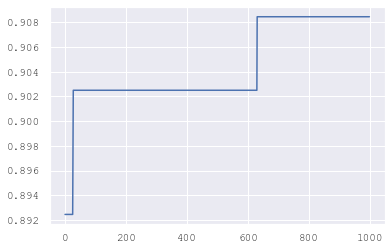

In [30]:
plt.plot(list(range(len(results)-1)), maxRes)
plt.show()

Well, the highest ROC AUC score found through random search gives almost identical results as this found manually.  
Now it would beneficial to narrow search ranges and perform it one more time, but I will leave as it is in this study.

#### Summary

To sum up, as anyone can imagine XGBoost and Random Forest estimators gave the best results, SVM and kNN perform almost exactly the same and all of the advanced algorithms have been significant improvent with comparison to basic Linear Regression